In [1]:
#Phylogenetic tree construction for BNI taxa
#author: Sheng-Kai Hsu
#created: 2023.02.28
#last edited: 2025.04.15
#note: change to Paspalum reference
#note 6/15: change to miniProt-based Alignment
#note 11/27: re-use in p_phyloGWAS

In [6]:
rm(list=ls())

library(ape)
library(pheatmap)
library(limma)
library(parallel)
library(tidyverse)
library(ggtree)

In [7]:
source("/workdir/sh2246/p_phyloGWAS/src/S01_phyloK.R")

Warning message in file(file, "r"):
“cannot open file '/home/sh2246/Dropbox/postDoc/projects/p_phyloGWAS/data/test/test.tree.newick': No such file or directory”


ERROR: Error in file(file, "r"): cannot open the connection


In [4]:
#load msa per transcript of the angiosperm 353 loci (and everything now)
fasta.list=list.files("/workdir/sh2246/p_phyloGWAS_archived/output/CDSMSAPerOG_gs",".gs.l0.fa$",full.names = T)
OGNames = gsub(".gs.l0.fa","",strsplit2(fasta.list,"/")[,7])
angio353 = read.table("/workdir/sh2246/p_phyloGWAS/output/angiosperm353ToOGName.txt",header = F)[,1]
fasta.list = fasta.list[substr(strsplit2(fasta.list,"/")[,7],1,9)%in%angio353]
fasta.aln=mclapply(fasta.list,function(x) read.FASTA(x),mc.cores = 5)
fasta.alnm=mclapply(fasta.aln,function(x) as.matrix(x),mc.cores = 2)


In [5]:
gc()

used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells   40593244  2168.0   59766708  3191.9   40701710  2173.8
Vcells 3144307188 23989.2 4634427507 35357.9 3861956151 29464.4

In [6]:
length(fasta.alnm)

[1] 413

In [7]:
fasta.alnm2 = mclapply(fasta.alnm,function(x) x[grep(":0$",rownames(x)),],mc.cores = 30)

In [8]:
fasta.alnm2 = mclapply(fasta.alnm2,function(x) {
    tmp = x
    rownames(tmp) = strsplit2(rownames(x),":")[,2]
    return(tmp)
},mc.cores = 30)

In [7]:
dir.create("/workdir/sh2246/p_phyloGWAS/output/geneTree_angiosperm353/")
# dir.create("/workdir/sh2246/p_phyloGWAS/output/geneTree_allOGs/")
for (i in 1:length(fasta.alnm2)){
    write.FASTA(fasta.alnm2[[i]],paste0("/workdir/sh2246/p_phyloGWAS/output/geneTree_angiosperm353/gene_",i,".fa"))
#      write.FASTA(fasta.alnm2[[i]],paste0("/workdir/sh2246/p_phyloGWAS/output/geneTree_allOGs/",OGNames[i],".fa"))
}

In [17]:
allTaxa = Reduce("union",lapply(fasta.alnm2,rownames))

In [18]:
fasta.alnm3 = mclapply(fasta.alnm2,function(x) {
    missTaxa = setdiff(allTaxa,rownames(x))
    tmp = matrix(rep("-",ncol(x)*length(missTaxa)),nrow = length(missTaxa),ncol = ncol(x),byrow = T)
    rownames(tmp) = missTaxa
    tmp = as.matrix(as.DNAbin(tmp))
    out = rbind(x,tmp)
    if (ncol(out) > 20) out = out[allTaxa,sample(1:ncol(out),20)]
    return(out)
},mc.cores = 30)


In [19]:
fasta.aln.merged=do.call(cbind, fasta.alnm3)

In [20]:
nrow(fasta.aln.merged)

[1] 800

In [72]:
d.angio353 =dist.dna(fasta.aln.merged,pairwise.deletion = T,model = "K81",as.matrix = T)

In [74]:
d.angio353[d.angio353==Inf] = NA
d.angio353[d.angio353>=0.3] = NA

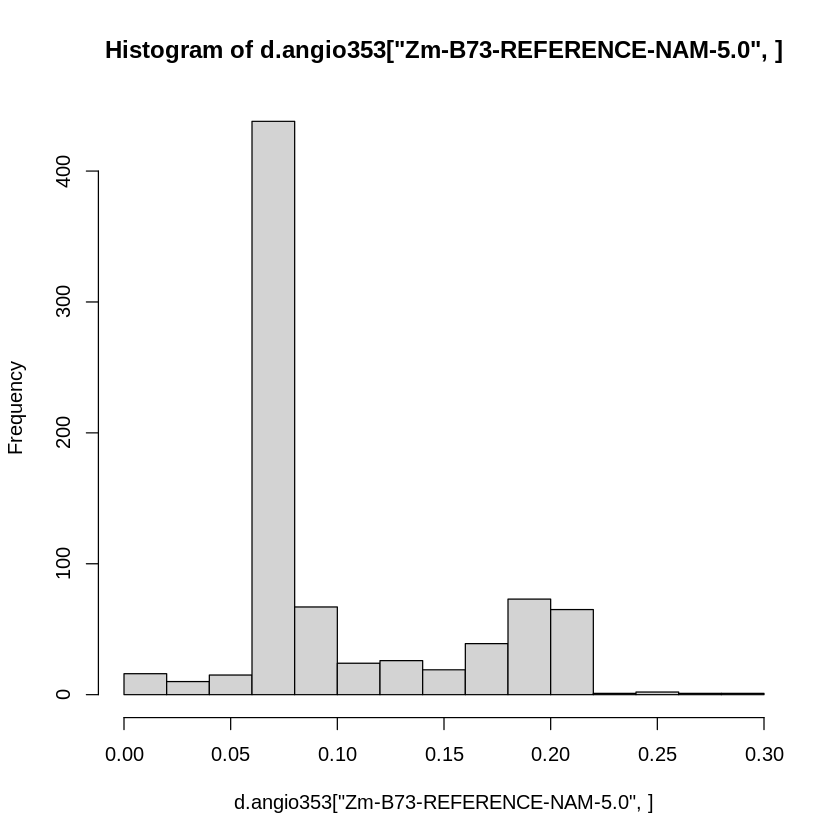

In [79]:
hist(d.angio353["Zm-B73-REFERENCE-NAM-5.0",])

In [84]:
write.table(d.angio353,"/workdir/sh2246/p_phyloGWAS/output/angiosperm353_geneticDistance.txt",col.names = T,row.names = F,quote = F,sep = "\t")

In [ ]:
# ASTRAL tree

In [8]:
metadata = read.csv("/workdir/sh2246/p_phyloGWAS/data/Poaceae_metadata_filtered_2025.04.07.csv",header = T)[,c(1,3)]
metadata$spTaxa = paste(metadata[,1],metadata[,2],sep = ":")

In [9]:
head(metadata)

assemblyID                         correctSpecies        
1 A17                                Hordeum bulbosum      
2 A42                                Hordeum bulbosum      
3 aegilops_longissima_6782_assembly  Aegilops longissima   
4 aegilops_sharonensis_1644_assembly Aegilops sharonensis  
5 AN21TSTL0187                       Schizachyrium delavayi
6 AN21TSTL0248                       Anatherum bicorne     
  spTaxa                                                 
1 A17:Hordeum bulbosum                                   
2 A42:Hordeum bulbosum                                   
3 aegilops_longissima_6782_assembly:Aegilops longissima  
4 aegilops_sharonensis_1644_assembly:Aegilops sharonensis
5 AN21TSTL0187:Schizachyrium delavayi                    
6 AN21TSTL0248:Anatherum bicorne

In [11]:
# astral tree
spTre = read.tree("/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral3_20250416.nwk")
spTre.rooted = root(spTre,"ASM1935983v1")
# spTre.rooted$edge.length[is.na(spTre.rooted$edge.length)] = 0.01

In [12]:
retainedSp = intersect(metadata$assemblyID,spTre.rooted$tip.label)

In [13]:
setdiff(metadata$assemblyID,spTre.rooted$tip.label)

[1] "Agropyron_cristatum"

In [14]:
spTre.rooted = keep.tip(spTre.rooted,retainedSp)

In [15]:
write.tree(spTre.rooted,"/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral3_filtered_20250416.nwk")

In [16]:
spTre.rooted.renamed=spTre.rooted
merge_tab5=data.frame(assemblyID=spTre.rooted$tip.label)
merge_tab5=merge(merge_tab5,metadata,by = "assemblyID")
merge_tab5=merge_tab5[!duplicated(merge_tab5$assemblyID),]
rownames(merge_tab5)=merge_tab5$assemblyID
merge_tab5=merge_tab5[spTre.rooted$tip.label,]

spTre.rooted.renamed$tip.label[!is.na(merge_tab5$spTaxa)] = merge_tab5$spTaxa[!is.na(merge_tab5$spTaxa)]

In [17]:
write.tree(spTre.rooted.renamed,"/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral3_spLabeled_20250416.nwk")

In [21]:
png("/workdir/sh2246/p_phyloGWAS/output/angiosperm353_astral3_spLabeled_20250416.png",
    height = 60,width = 20, unit = "cm",pointsize = 6,res = 600)
ggtree(spTre.rooted.renamed,size =.3,ladderize = T ) + 
xlim(c(0,.8)) +
geom_tiplab(hjust = -.025,size=1) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 
dev.off()

pdf 
  2

In [18]:
spTre.rooted.renamed$tip.label[grep("diplo",spTre.rooted.renamed$tip.label)]

[1] "Zd-Gigi-REFERENCE-PanAnd-1.0:Zea diploperennis"
[2] "Zd-Momo-REFERENCE-PanAnd-1.0:Zea diploperennis"
[3] "AN21TS49:Zea diploperennis"                    
[4] "MCRTL020:Zea diploperennis"

In [19]:
potInPotSp = c("Zm-B73-REFERENCE-NAM-5.0:Zea mays","Zd-Gigi-REFERENCE-PanAnd-1.0:Zea diploperennis",
               "Sorghum_bicolor_NCBIv3:Sorghum bicolor","Sn-CAM1369-DRAFT-PanAnd-1.0:Sorghastrum nutans",
               "Td-FL_9056069_6-REFERENCE-PanAnd-2.0a:Tripsacum dactyloides",
               "Ag-CAM1351-DRAFT-PanAnd-1.0:Andropogon gerardii",
               "Av-Kellogg1287_8-REFERENCE-PanAnd-1.0:Anatherum virginicum",
               "Bl-K1279B-DRAFT-PanAnd-1.0:Bothriochloa laguroides",
               "Et-Layton_Zhong168-DRAFT-PanAnd-1.0:Elionurus tripsacoides",
               "Ss-CAM1384-DRAFT-PanAnd-1.0:Schizachyrium scoparium",
               "Tt-AUB21_1-DRAFT-PanAnd-1.0:Themeda triandra",
               "A1014002:Chrysopogon zizanioides","Msinensis_497_v7.0:Miscanthus sinensis",
               "P.virgatum_v5:Panicum virgatum")
potInPotTre = keep.tip(spTre.rooted.renamed,potInPotSp)

In [20]:
potInPotTre = root(potInPotTre,"P.virgatum_v5:Panicum virgatum")

In [25]:
potInPotTre$tip.label = limma::strsplit2(potInPotTre$tip.label,":")[,2]

In [33]:
png("/workdir/sh2246/p_phyloGWAS/output/potInPotSpTre.png",
    height = 8.7,width = 8.7, unit = "cm",pointsize = 6,res = 600)
ggtree(potInPotTre,size =1,ladderize = T) + 
geom_tiplab(hjust = -.05,size=3) +
xlim(0,13) +
scale_y_reverse()
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


png 
  2

In [65]:
ZeaTre = keep.tip(spTre.rooted.renamed,spTre.rooted.renamed$tip.label[grep("Zea",spTre.rooted.renamed$tip.label)])

In [66]:
ZeaTre = keep.tip(ZeaTre,c("Zm-B73-REFERENCE-NAM-5.0:Zea mays",'Zx-TIL18-REFERENCE-PanAnd-1.0:Zea mays subsp. mexicana',
                           "Zh-RIMHU001-REFERENCE-PanAnd-1.0:Zea mays subsp . huehuetenangensis",
                           "Zv-TIL11-REFERENCE-PanAnd-1.0:Zea mays subsp. parviglumis"))

In [67]:
ZeaTre$tip.label = limma::strsplit2(ZeaTre$tip.label,":")[,2]

In [68]:
ZeaTre = root(ZeaTre,"Zea mays subsp . huehuetenangensis")

In [82]:
ZeaTre$tip.label[2:3] = ZeaTre$tip.label[c(3,2)]

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


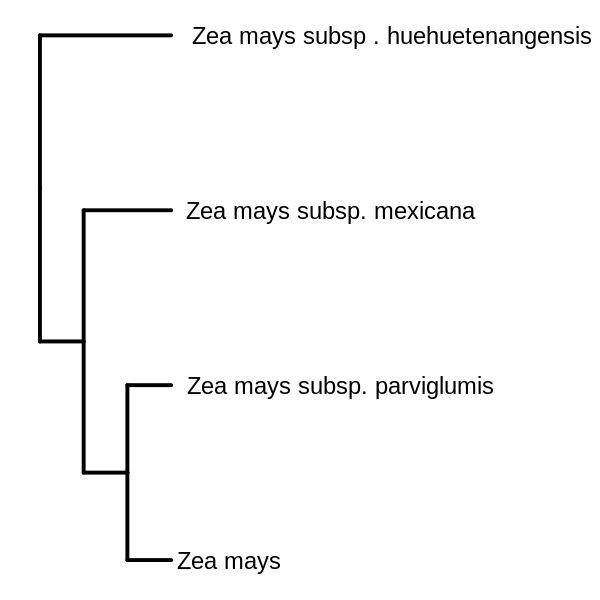

In [83]:
options(repr.plot.width=5, repr.plot.height=5)
ggtree(ZeaTre,size =1.1,ladderize = T ,branch.length = "none") + 
geom_tiplab(hjust = -.05,size=5) +
xlim(0,12) +
scale_y_reverse()

# phyloK matrix

In [22]:
K2 = phyloK(spTre.rooted)

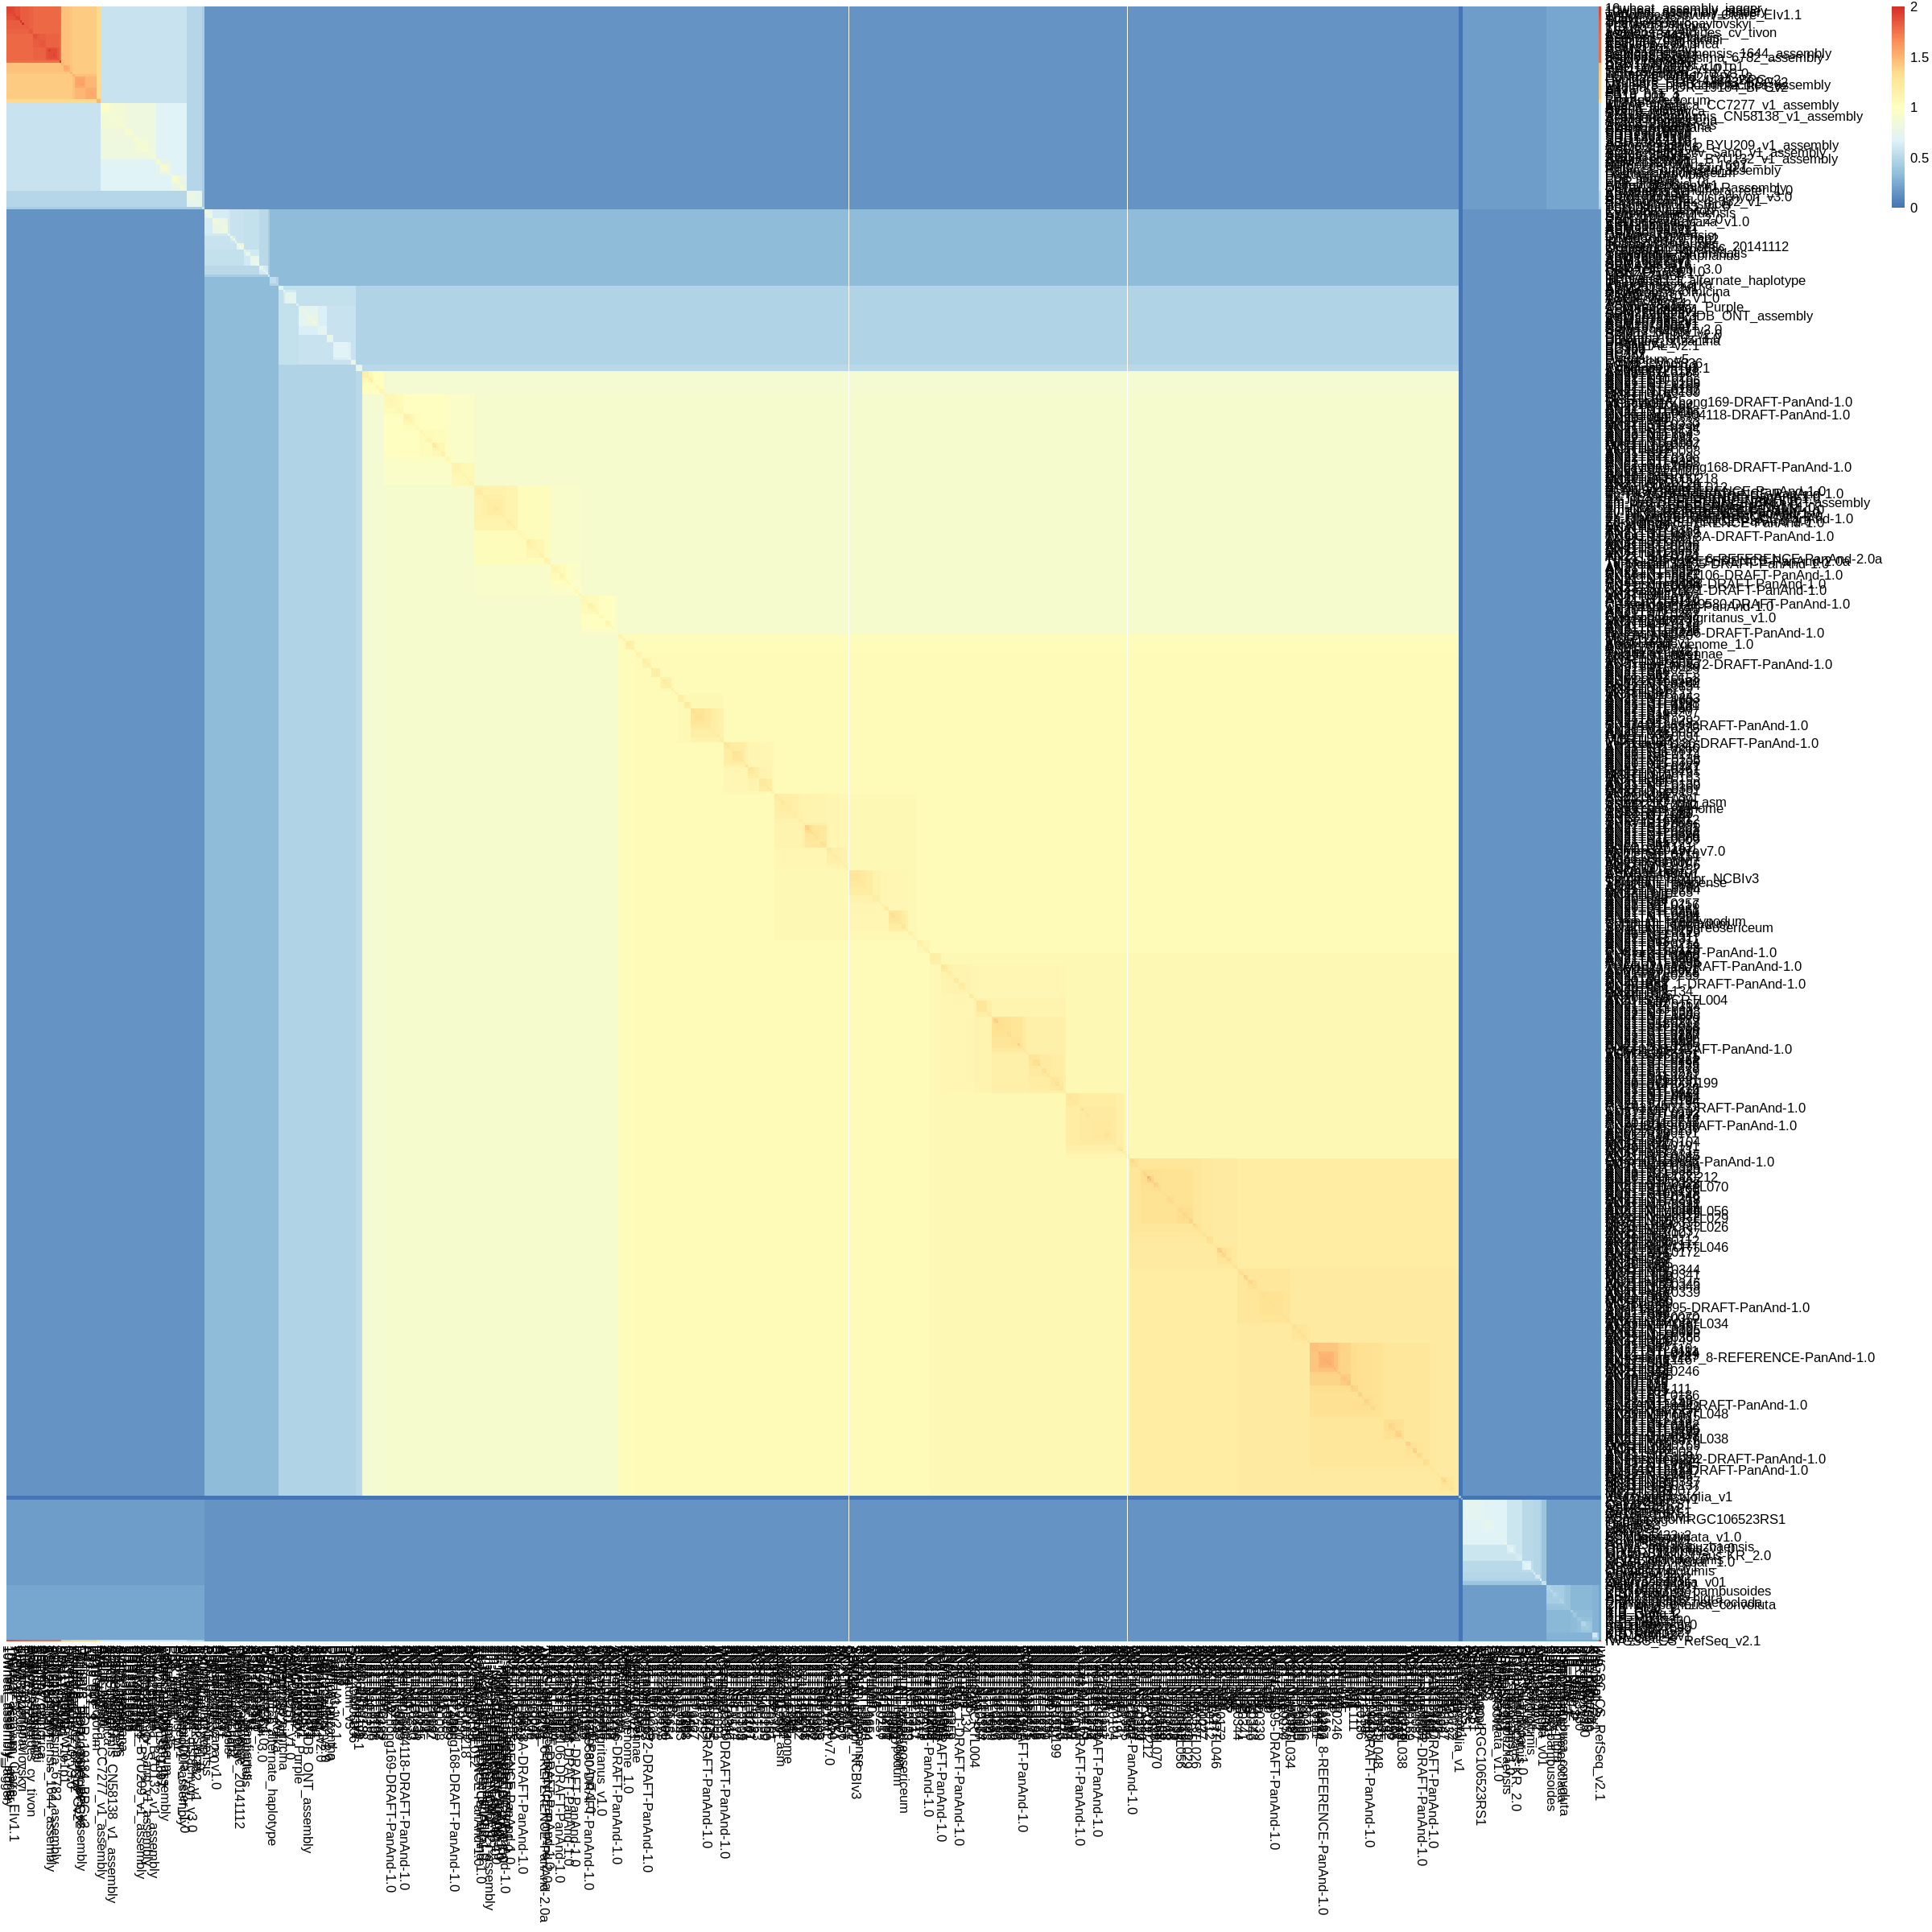

In [23]:
options(repr.plot.width=20, repr.plot.height=20)
pheatmap(K2,cluster_row = F, cluster_col = F)

In [24]:
write.table(K2,"/workdir/sh2246/p_phyloGWAS/output/phyloK_728Poaceae_astral_20250416.txt",sep = "\t",quote = F)

In [83]:
K = read.table("/workdir/sh2246/p_phyloGWAS/output/phyloK_728Poaceae_astral_20250407.txt")

In [84]:
colnames(K) = rownames(K)

[1] 0.9685452

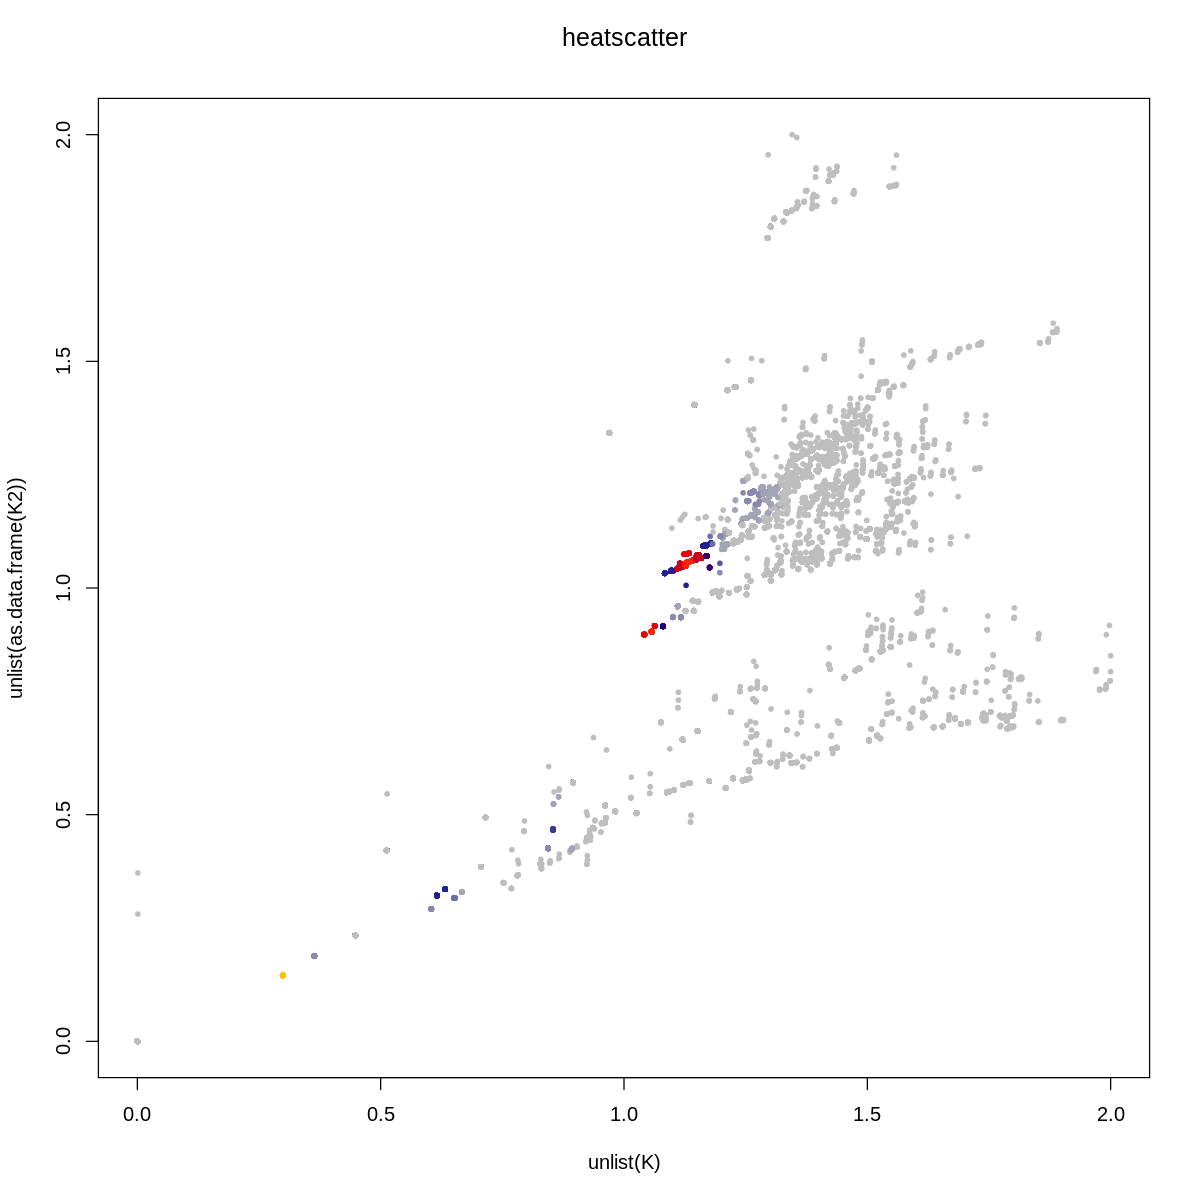

In [85]:
options(repr.plot.width=10, repr.plot.height=10)
LSD::heatscatter(unlist(K),unlist(as.data.frame(K2)))
cor(unlist(K),unlist(as.data.frame(K2)))

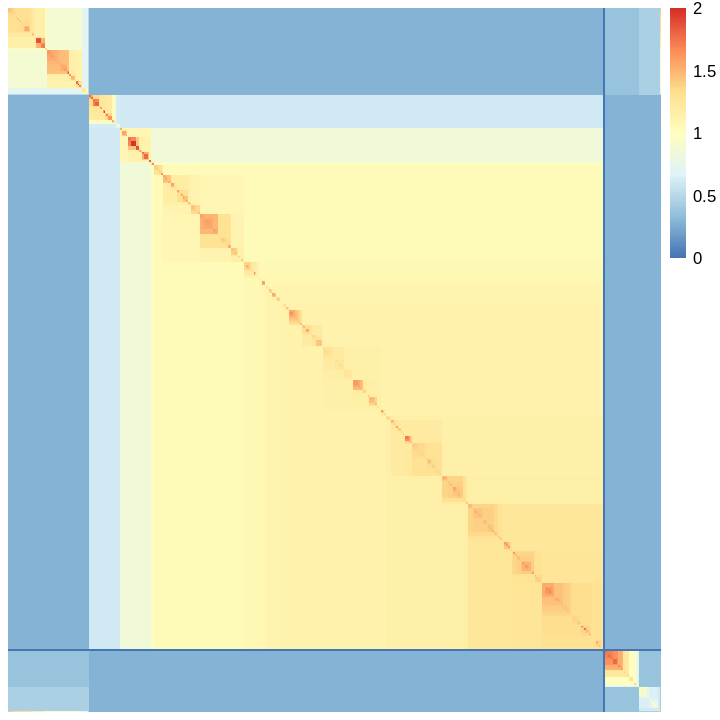

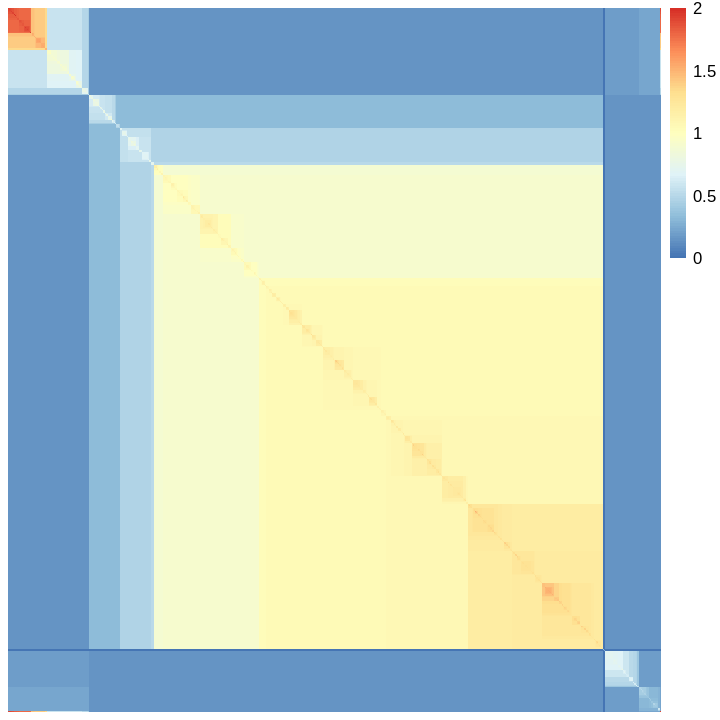

In [88]:
options(repr.plot.width=6, repr.plot.height=6)
pheatmap(K[spTre.rooted$tip.label,spTre.rooted$tip.label],cluster_rows = F,cluster_cols = F,show_rownames = F,show_colnames = F)
pheatmap(K2[spTre.rooted$tip.label,spTre.rooted$tip.label],cluster_rows = F,cluster_cols = F,show_rownames = F,show_colnames = F)

In [36]:
metadata = read.csv("/workdir/sh2246/p_phyloGWAS/data/Poaceae_metadata_filtered_2025.04.07.csv",header = T)

In [57]:
oldTre = read.tree("/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral_filtered_20250407.nwk")
oldTre.rooted = root(oldTre,"ASM1935983v1")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


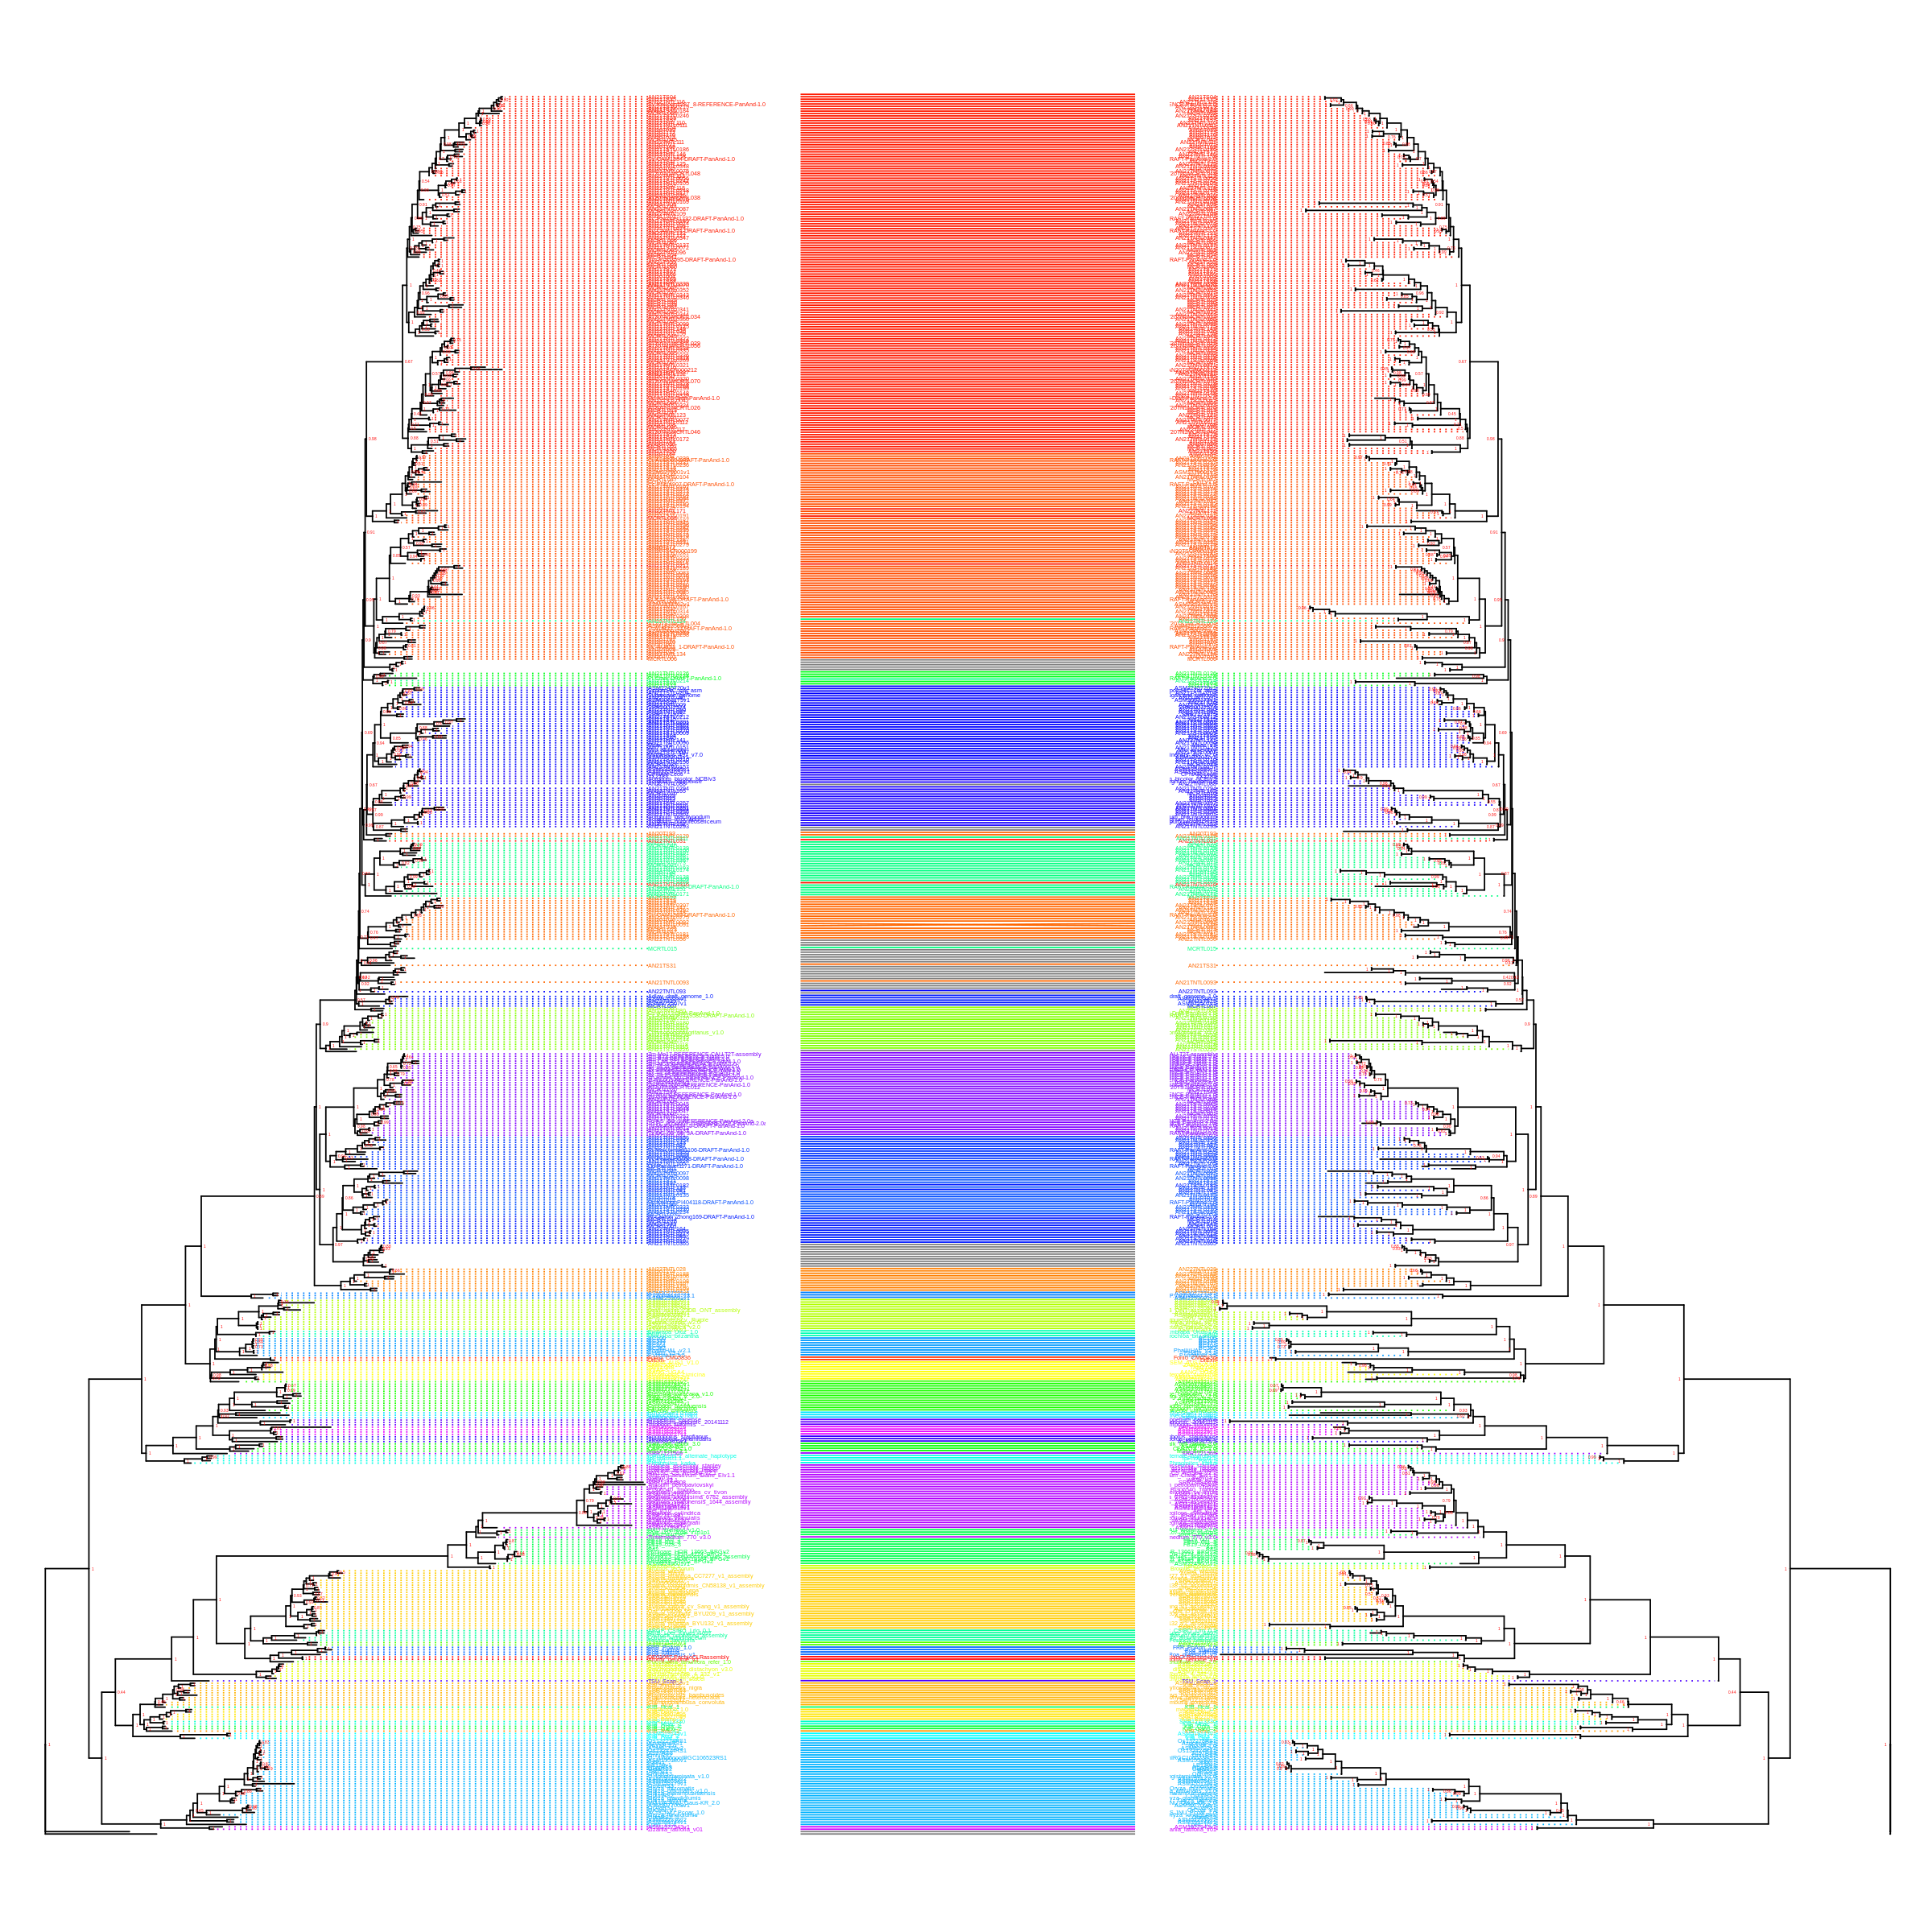

In [64]:
library(cowplot)

options(repr.plot.width=20, repr.plot.height=20)
T1=ggtree(spTre.rooted)+
    theme_tree2(legend.position='none',plot.margin = unit(c(0,0,0,0),"cm"))+
    geom_tiplab()
T2=ggtree(oldTre.rooted)+
    theme_tree2(legend.position='none',plot.margin = unit(c(0,0,0,0),"cm"))+
    geom_tiplab(hjust=1)+ scale_x_reverse()

d1 = T1$data[T1$data$isTip,]  
d1$x[] = 1  
d2 = T2$data[T2$data$isTip,]  
d2$x[] = 2  

TTcon = rbind(d1, d2) 
TTcon$subtribe = metadata[TTcon$label,]$subtribe
TTcon$subtribe[is.na(TTcon$subtribe)] = "unknown"
TTcon$subtribe = factor(metadata[TTcon$label,]$subtribe,
                        levels = c(sort(unique(metadata[TTcon$label,]$subtribe)),"unknown"))
subtribe_col1 = rainbow(60)[factor(metadata[spTre.rooted$tip.label,]$subtribe,
                        levels = c(sort(unique(metadata[spTre.rooted$tip.label,]$subtribe))))]
subtribe_col2 = rainbow(60)[factor(metadata[oldTre.rooted$tip.label,]$subtribe,
                        levels = c(sort(unique(metadata[oldTre.rooted$tip.label,]$subtribe))))]
spTre.rooted$node.label = round(as.numeric(strsplit2(spTre.rooted$node.label,"-")[,1]),2)
T1 = ggtree(spTre.rooted) + 
    ylim(1,728)+
    xlim(0,.8)+
    geom_nodelab(vjust=.5,hjust = 0.1, size=1,color = "red") +
  geom_tiplab(align = T,size=1.5,color=subtribe_col1)  

oldTre.rooted$node.label = round(as.numeric(strsplit2(oldTre.rooted$node.label,"-")[,1]),2)
T2 = ggtree(oldTre.rooted) +   
    geom_tiplab(hjust =1, align = T,size=1.5,color=subtribe_col2)  +
    ylim(1,728)+
    geom_nodelab(vjust=.5,hjust = 1, size=1,color = "red") +
    scale_x_reverse(lim = c(20,0)) 

L1 = ggplot(TTcon, aes(x = x, y = y, col = subtribe, group = label)) + geom_line() +   
    scale_color_manual(values = c(rainbow(60)[1:50],"grey"))+
    theme_void() + 
    theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm"))

cowplot::plot_grid(T1, L1 ,T2, nrow = 1, align = "hv",rel_widths = c(2,1,2))

In [39]:
rownames(metadata) = metadata$assemblyID

In [ ]:
# comparison to Michelle's tree

In [193]:
metadata = read.csv("/workdir/sh2246/p_phyloGWAS/data/Poaceae_metadata_2025.04.02.csv",header = T)

In [194]:
TABASCO = read.csv("/workdir/sh2246/p_phyloGWAS/data/tabasco_Poaceae800.csv")
TABASCO = merge(TABASCO,metadata[,c(1,9)],by = "assemblyID",all.x = T)
TABASCO = TABASCO[!duplicated(TABASCO[,1]),]
rownames(TABASCO) = TABASCO$assemblyID

In [234]:
taxanomicGroup = read.csv("/workdir/sh2246/p_phyloGWAS/data/Poaceae_taxonomic_groups_subtribeAdded_SKH20250402.csv",header = T)
taxanomicGroup = taxanomicGroup[!duplicated(taxanomicGroup$assemblyID),]
rownames(taxanomicGroup) = taxanomicGroup$assemblyID

In [197]:
mTre = read.tree("/workdir/sh2246/p_phyloGWAS/data/angiosperm353_ASTRALPRO3.greaterthan50genespersample.tre")

In [238]:
mTre


Phylogenetic tree with 482 tips and 481 internal nodes.

Tip labels:
  AN21TS53_Anatherum-macrothrix, AN21TS57_Anatherum-selloanum, AN22TNTL110_Andropogon-carinatus, AN21TNTL0111_Andropogon-ingratus, AN21TSTL0184_Anatherum-glomeratum, AN21TS04_Anatherum-brachystachyum, ...
Node labels:
  NA-NA-NA-NA, 1.00-0.98-0.01-0.01, 0.81-0.40-0.25-0.35, 0.54-0.36-0.32-0.32, 0.82-0.40-0.28-0.32, 0.47-0.35-0.34-0.31, ...

Rooted; includes branch length(s).

In [350]:
androIdx = which(spTre.rooted$tip.label%in%taxanomicGroup[taxanomicGroup[,5]%in%"Andropogoneae"|taxanomicGroup[,1]=="P.vaginatum_v3.1",1])
spTre.rooted.renamed.andro = keep.tip(spTre.rooted.renamed,tip = androIdx)

In [351]:
spTre.rooted.renamed.andro


Phylogenetic tree with 500 tips and 499 internal nodes.

Tip labels:
  P.vaginatum_v3.1:Paspalum vaginatum, AN21TSTL0188:Arthraxon hispidus, AN20T174:Arthraxon antsirabensis, AN22TNTL028:Arthraxon cuspidatus, AN21TS30:Arthraxon junnarensis, AN21TNTL0106:Arthraxon lancifolius, ...
Node labels:
  1.000000, 0.890232, 1.000000, 1.000000, 1.000000, 1.000000, ...

Rooted; includes branch length(s).

In [319]:
mTre.renamed = mTre
mTre.renamed$tip.label = gsub("_",":",mTre.renamed$tip.label)
mTre.renamed$tip.label = gsub("-"," ",mTre.renamed$tip.label)

In [320]:
mTre.renamed$tip.label[mTre.renamed$tip.label=="Paspalum:vaginatum"] = "P.vaginatum_v3.1:Paspalum vaginatum"

In [321]:
# panand longread
mTre.renamed$tip.label[mTre.renamed$tip.label=='"Andropogon":burmanicus'] = 'Ab-Traiperm_572-DRAFT-PanAnd-1.0:Andropogon burmanicus'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Andropogon:chinensis'] = 'Ac-Pasquet1232-DRAFT-PanAnd-1.0:Andropogon chinensis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Andropogon:gerardi'] = 'Ag-CAM1351-DRAFT-PanAnd-1.0:Andropogon gerardii'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Anatherum:virginicum'] = 'Av-Kellogg1287_8-REFERENCE-PanAnd-1.0:Anatherum virginicum'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Bothriochloa:laguroides'] = 'Bl-K1279B-DRAFT-PanAnd-1.0:Bothriochloa laguroides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Chrysopogon:serrulatus'] = 'Cs-KelloggPI219580-DRAFT-PanAnd-1.0:Chrysopogon serrulatus'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Cymbopogon:citratus'] = 'Cc-PI314907-DRAFT-PanAnd-1.0:Cymbopogon citratus'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Cymbopogon:refractus'] = 'Cr-AUB069-DRAFT-PanAnd-1.0:Cymbopogon refractus'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Elionurus:tripsacoides'] = 'Et-Layton_Zhong168-DRAFT-PanAnd-1.0:Elionurus tripsacoides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Hemarthria:compressa'] = 'Hp-KelloggPI404118-DRAFT-PanAnd-1.0:Hemarthria compressa'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Heteropogon:contortus'] = 'Hc-AUB53_1-DRAFT-PanAnd-1.0:Heteropogon contortus'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Ischaemum:rugosum'] = 'Ir-Pasquet1136-DRAFT-PanAnd-1.0:Ischaemum rugosum'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Pogonatherum:paniceum'] = 'Pi-Clark-DRAFT-PanAnd-1.0:Pogonatherum paniceum'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Rhytachne:rottboellioides'] = 'Rr-Malcomber3106-DRAFT-PanAnd-1.0:Rhytachne rottboellioides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Rottboellia:tuberculosa'] = 'Rt-Layton_Zhong169-DRAFT-PanAnd-1.0:Rottboellia tuberculosa'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Schizachyrium:microstachyum'] = 'Sm-PI203595-DRAFT-PanAnd-1.0:Schizachyrium microstachyum'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Schizachyrium:scoparium'] = 'Ss-CAM1384-DRAFT-PanAnd-1.0:Schizachyrium scoparium'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Sorghastrum:nutans'] = 'Sn-CAM1369-DRAFT-PanAnd-1.0:Sorghastrum nutans'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Sorghum:bicolor'] = 'Sorghum_bicolor_NCBIv3:Sorghum bicolor'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Thelepogon:elegans'] = 'Te-Pasquet1246-DRAFT-PanAnd-1.0:Thelepogon elegans'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Themeda:triandra'] = 'Tt-AUB21_1-DRAFT-PanAnd-1.0:Themeda triandra'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Tripsacum:dactyloides:FL'] = 'Td-FL_9056069_6-REFERENCE-PanAnd-2.0a:Tripsacum dactyloides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Tripsacum:dactyloides:FL:Hap2'] = 'Td-FL_9056069_6-REFERENCE-PanAnd-2.0b:Tripsacum dactyloides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Tripsacum:dactyloides:KS'] = 'Td-KS_B6_1-REFERENCE-PanAnd-2.0a:Tripsacum dactyloides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Tripsacum:dactyloides:KS:Hap2'] = 'Td-KS_B6_1-REFERENCE-PanAnd-2.0b:Tripsacum dactyloides'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Urelytrum:digitatum'] = 'Ud-Pasquet1171-DRAFT-PanAnd-1.0:Urelytrum digitatum'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Vossia:cuspidata'] = 'Vc-Pasquet1098-DRAFT-PanAnd-1.0:Vossia cuspidata'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:diploperennis:Gigi'] = 'Zd-Gigi-REFERENCE-PanAnd-1.0:Zea diploperennis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:diploperennis:Momo'] = 'Zd-Momo-REFERENCE-PanAnd-1.0:Zea diploperennis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:luxurians'] = 'Zl-RIL003-REFERENCE-PanAnd-1.0:Zea luxurians'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:huehuetengensis'] = 'Zh-RIMHU001-REFERENCE-PanAnd-1.0:Zea mays subsp. huehuetenangensis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:mays:B73v5'] = 'Zm-B73-REFERENCE-NAM-5.0:Zea mays'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:mexicana:TIL18'] = 'Zx-TIL18-REFERENCE-PanAnd-1.0:Zea mays subsp. mexicana'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:mexicana:TIL25'] = 'Zx-TIL25-REFERENCE-PanAnd-1.0:Zea mays subsp. mexicana'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:parviglumis:TIL01'] = 'Zv-TIL01-REFERENCE-PanAnd-1.0:Zea mays subsp. parviglumis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:mays:ssp.:parviglumis:TIL11'] = 'Zv-TIL11-REFERENCE-PanAnd-1.0:Zea mays subsp. parviglumis'
mTre.renamed$tip.label[mTre.renamed$tip.label=='Zea:nicaraguensis'] = 'Zn-PI615697-REFERENCE-PanAnd-1.0:Zea nicaraguensis'


In [322]:
#merged shortread
mTre.renamed$tip.label = gsub("merged","",mTre.renamed$tip.label)

In [352]:
#present in Sheng-Kai's but not in Michelle's tree
diff_SKtoM = setdiff(spTre.rooted.renamed.andro$tip.label,mTre.renamed$tip.label)
diff_MtoSK = setdiff(mTre.renamed$tip.label,spTre.rooted.renamed.andro$tip.label)
names(diff_MtoSK) = strsplit2(diff_MtoSK,":")[,1]
names(diff_SKtoM) = strsplit2(diff_SKtoM,":")[,1]
length(diff_SKtoM)
length(diff_MtoSK)

[1] 43

[1] 25

In [325]:
trslTab = cbind(Michelle = diff_MtoSK[sort(intersect(names(diff_MtoSK),names(diff_SKtoM)))],
                ShengKai = diff_SKtoM[sort(intersect(names(diff_MtoSK),names(diff_SKtoM)))])

In [326]:
for(i in 1:nrow(trslTab)){
    mTre.renamed$tip.label[mTre.renamed$tip.label==trslTab[i,1]] =trslTab[i,2]
}

In [353]:
#present in Sheng-Kai's but not in Michelle's tree
diff_SKtoM = setdiff(spTre.rooted.renamed.andro$tip.label,mTre.renamed$tip.label)
diff_MtoSK = setdiff(mTre.renamed$tip.label,spTre.rooted.renamed.andro$tip.label)
names(diff_MtoSK) = strsplit2(diff_MtoSK,":")[,1]
names(diff_SKtoM) = strsplit2(diff_SKtoM,":")[,1]
length(diff_SKtoM)
length(diff_MtoSK)

[1] 43

[1] 25

In [354]:
sort(diff_SKtoM)

Adlay_draft_genome_1.0 
              "Adlay_draft_genome_1.0:Coix lacryma-jobi" 
                                                AN20T004 
                    "AN20T004:Schizachyrium brevifolium" 
                                            AN21TNTL0362 
                      "AN21TNTL0362:Saccharum baldwinii" 
                                            AN21TNTL0363 
                      "AN21TNTL0363:Erianthus giganteus" 
                                            ASM1813568v1 
                         "ASM1813568v1:Themeda triandra" 
                                            ASM1932011v1 
                    "ASM1932011v1:Miscanthus floridulus" 
                                            ASM2063173v1 
                    "ASM2063173v1:Saccharum officinarum" 
                                            ASM2203655v1 
                    "ASM2203655v1:Microstegium vimineum" 
                                            ASM2245720v1 
                     "ASM2245720v1:Saccharum spontaneum" 
                                            ASM2333362v1 
                   "ASM2333362v1:Bothriochloa decipiens" 
                                            ASM2560326v1 
                         "ASM2560326v1:Themeda triandra" 
                                            ASM2779001v1 
                     "ASM2779001v1:Cymbopogon flexuosus" 
                                            ASM2944929v1 
                            "ASM2944929v1:Zea luxurians" 
                                            ASM3354695v1 
                          "ASM3354695v1:Sorghum bicolor" 
                                            ASM3354697v1 
                          "ASM3354697v1:Sorghum bicolor" 
                                             ASM972507v1 
                             "ASM972507v1:Coix aquatica" 
                                             ASM976338v1 
                         "ASM976338v1:Coix lacryma-jobi" 
                                               Ccit.v1.0 
                         "Ccit.v1.0:Cymbopogon citratus" 
                              ChrysopogonNigritanus_v1.0 
     "ChrysopogonNigritanus_v1.0:Chrysopogon nigritanus" 
                                             CPNAM-Leoti 
                           "CPNAM-Leoti:Sorghum bicolor" 
                               Cs-A1013-Draft-PanAnd-1.0 
      "Cs-A1013-Draft-PanAnd-1.0:Chrysopogon serrulatus" 
                               Hd-A1025-Draft-PanAnd-1.0 
       "Hd-A1025-Draft-PanAnd-1.0:Hyparrhenia diplandra" 
                                                MCRTL011 
                       "MCRTL011:Urelytrum agropyroides" 
                                            Mlu_assembly 
               "Mlu_assembly:Miscanthus lutarioriparius" 
                                                 Msac_v3 
                     "Msac_v3:Miscanthus sacchariflorus" 
                                      Msinensis_497_v7.0 
                "Msinensis_497_v7.0:Miscanthus sinensis" 
                                     Sorghum_brachypodum 
               "Sorghum_brachypodum:Sorghum brachypodum" 
                                       Sorghum_halepense 
                   "Sorghum_halepense:Sorghum halepense" 
                                      Sorghum_leiocladum 
                 "Sorghum_leiocladum:Sorghum leiocladum" 
                                Sorghum_purpureosericeum 
     "Sorghum_purpureosericeum:Sorghum purpureosericeum" 
                                             SRR20072574 
                          "SRR20072574:Saccharum fulvum" 
                                              SRR7121975 
                     "SRR7121975:Saccharum longisetosum" 
                                       Sspon.HiC_chr_asm 
                "Sspon.HiC_chr_asm:Saccharum spontaneum" 
                                        Sugarcane_genome 
                 "Sugarcane_genome:Saccharum spontaneum" 
                         Td-McKain334_5-DRAFT-PanAnd-1.0 
 "Td-McKain334_5-DRAFT-PanAnd-1.

In [355]:
sort(diff_MtoSK)

AN20T001 
                           "AN20T001:Eriochrysis cayennensis" 
                                                     AN20T004 
                                    "AN20T004:Andropogon sp." 
                                                     AN20T005 
                              "AN20T005:Sorghum arundinaceum" 
                                                     AN20T194 
                           "AN20T194:Ischaemum heterotrichum" 
                                                     AN20T197 
                                "AN20T197:Microstegium nudum" 
                                                 AN21TNTL0073 
            "AN21TNTL0073:Andropogon gayanus var. polycladus" 
                                                 AN21TNTL0081 
                       "AN21TNTL0081:Bothriochloa hirtifolia" 
                                                 AN21TNTL0082 
                       "AN21TNTL0082:Bothriochloa hirtifolia" 
                                                 AN21TNTL0298 
                             "AN21TNTL0298:Spodiopogon lacei" 
                                                 AN21TNTL0362 
                            "AN21TNTL0362:Tripidium strictum" 
                                                 AN21TNTL0363 
                           "AN21TNTL0363:Saccharum giganteum" 
                                                     AN21TS46 
                                   "AN21TS46:Tripsacum laxum" 
                                                 AN21TSTL0036 
                               "AN21TSTL0036:Hyparrhenia sp." 
                                                 AN21TSTL0179 
                             "AN21TSTL0179:Anatherum bicorne" 
                                                 AN21TSTL0218 
                         "AN21TSTL0218:Bothriochloa radicans" 
                                                 AN21TSTL0220 
                             "AN21TSTL0220:Anatherum bicorne" 
                                                 AN21TSTL0221 
                       "AN21TSTL0221:Eriochrysis cayennensis" 
                                                 AN21TSTL0222 
                          "AN21TSTL0222:Sorghum arundinaceum" 
                                                 AN21TSTL0224 
                          "AN21TSTL0224:Sorghum arundinaceum" 
                                                 AN21TSTL0240 
                           "AN21TSTL0240:Bothriochloa campii" 
                                                 AN21TSTL0241 
                           "AN21TSTL0241:Arthraxon prionodes" 
                                                  AN22TNTL025 
                        "AN22TNTL025:Eremochloa ciliatifolia" 
                                                  AN22TNTL166 
                            "AN22TNTL166:Urelytrum giganteum" 
                        Td-FL_9056069_6-REFERENCE-PanAnd-2.0b 
"Td-FL_9056069_6-REFERENCE-PanAnd-2.0b:Tripsacum dactyloides" 
                             Td-KS_B6_1-REFERENCE-PanAnd-2.0b 
     "Td-KS_B6_1-REFERENCE-PanAnd-2.0b:Tripsacum dactyloides"

In [356]:
sort(diff_SKtoM[grepl('AN2|MCRTL',names(diff_SKtoM))])
sum(grepl('AN2|MCRTL',names(diff_SKtoM)))

AN20T004                         AN21TNTL0362 
"AN20T004:Schizachyrium brevifolium"   "AN21TNTL0362:Saccharum baldwinii" 
                        AN21TNTL0363                             MCRTL011 
  "AN21TNTL0363:Erianthus giganteus"    "MCRTL011:Urelytrum agropyroides"

[1] 4

In [357]:
TABASCO[names(diff_SKtoM[grepl('^A10',names(diff_SKtoM))]),]

assemblyID complete duplicated fraged missing technology

In [358]:
TABASCO[names(diff_SKtoM[!grepl('^A10|PanAnd|ChrysopogonNigritanus|AN2|MCRTL',names(diff_SKtoM))]),]

assemblyID                         complete
ASM2944929v1                       ASM2944929v1                       1153    
Zm-Mo17-REFERENCE-CAU-T2T-assembly Zm-Mo17-REFERENCE-CAU-T2T-assembly 3852    
Zm-P39-REFERENCE-NAM-1.0           Zm-P39-REFERENCE-NAM-1.0           3843    
Zm-NC350-REFERENCE-NAM-1.0         Zm-NC350-REFERENCE-NAM-1.0         3837    
Zm-CML322-REFERENCE-NAM-1.0        Zm-CML322-REFERENCE-NAM-1.0        3833    
Zx-PI566673-REFERENCE-YAN-1.0      Zx-PI566673-REFERENCE-YAN-1.0      3582    
ASM976338v1                        ASM976338v1                        4986    
Adlay_draft_genome_1.0             Adlay_draft_genome_1.0             5104    
ASM972507v1                        ASM972507v1                        5379    
Tripidium_ravennae                 Tripidium_ravennae                 5287    
ASM2203655v1                       ASM2203655v1                       1172    
ASM2063173v1                       ASM2063173v1                          0    
Sspon.HiC_chr_asm                  Sspon.HiC_chr_asm                    24    
ASM2245720v1                       ASM2245720v1                         17    
Sugarcane_genome                   Sugarcane_genome                   1157    
SRR20072574                        SRR20072574                        5485    
SRR7121975                         SRR7121975                         1590    
ASM1932011v1                       ASM1932011v1                        781    
Msinensis_497_v7.0                 Msinensis_497_v7.0                  694    
Msac_v3                            Msac_v3                            3141    
Mlu_assembly                       Mlu_assembly                        467    
CPNAM-Leoti                        CPNAM-Leoti                        5572    
ASM3354697v1                       ASM3354697v1                       5582    
ASM3354695v1                       ASM3354695v1                       5584    
TX2783                             TX2783                             5587    
Sorghum_halepense                  Sorghum_halepense                  5089    
Sorghum_brachypodum                Sorghum_brachypodum                3337    
Sorghum_leiocladum                 Sorghum_leiocladum                 4202    
Sorghum_purpureosericeum           Sorghum_purpureosericeum           4940    
ASM1813568v1                       ASM1813568v1                       4604    
ASM2560326v1                       ASM2560326v1                       3681    
ASM2333362v1                       ASM2333362v1                        497    
Ccit.v1.0                          Ccit.v1.0                          3921    
ASM2779001v1                       ASM2779001v1                       4746    
                                   duplicated fraged missing
ASM2944929v1                       4437          2     0    
Zm-Mo17-REFERENCE-CAU-T2T-assembly 1737          3     0    
Zm-P39-REFERENCE-NAM-1.0           1746          2     1    
Zm-NC350-REFERENCE-NAM-1.0         1748          5     2    
Zm-CML322-REFERENCE-NAM-1.0        1753          4     2    
Zx-PI566673-REFERENCE-YAN-1.0      1462        370   178    
ASM976338v1                         554         29    23    
Adlay_draft_genome_1.0              224        135   129    
ASM972507v1                         177         21    15    
Tripidium_ravennae                   86        219     0    
ASM2203655v1                       4265         87    68    
ASM2063173v1                       5590          1     1    
Sspon.HiC_chr_asm                  5568          0     0    
ASM2245720v1                       5575          0     0    
Sugarcane_genome                   4183        201    51    
SRR20072574                          40         67     0    
SRR7121975                         2782       1220     0    
ASM1932011v1                       4765         26    20    
Msinensis_497_v7.0                 4898          0     0    
Msac_v3                            1666        767

In [247]:
TABASCO[names(diff_SKtoM[grepl('PanAnd|ChrysopogonNigritanus',names(diff_SKtoM))]),]

assemblyID                      complete
Tz-DC_05_58_3A-DRAFT-PanAnd-1.0 Tz-DC_05_58_3A-DRAFT-PanAnd-1.0  122    
Td-McKain334_5-DRAFT-PanAnd-1.0 Td-McKain334_5-DRAFT-PanAnd-1.0  415    
Cs-A1013-Draft-PanAnd-1.0       Cs-A1013-Draft-PanAnd-1.0       2996    
ChrysopogonNigritanus_v1.0      ChrysopogonNigritanus_v1.0      3676    
Hd-A1025-Draft-PanAnd-1.0       Hd-A1025-Draft-PanAnd-1.0        300    
                                duplicated fraged missing
Tz-DC_05_58_3A-DRAFT-PanAnd-1.0 5469        1     0      
Td-McKain334_5-DRAFT-PanAnd-1.0 5168        5     4      
Cs-A1013-Draft-PanAnd-1.0       2583       10     3      
ChrysopogonNigritanus_v1.0      1901       11     4      
Hd-A1025-Draft-PanAnd-1.0       5284        6     2      
                                technology                              
Tz-DC_05_58_3A-DRAFT-PanAnd-1.0 PacBio                                  
Td-McKain334_5-DRAFT-PanAnd-1.0 PacBio                                  
Cs-A1013-Draft-PanAnd-1.0       Oxford Nanopore MinION; Illumina NovaSeq
ChrysopogonNigritanus_v1.0      NA                                      
Hd-A1025-Draft-PanAnd-1.0       Oxford Nanopore MinION; Illumina NovaSeq

In [263]:
cbind(TABASCO[rownames(TABASCO)%in%names(diff_SKtoM)[grepl('AN2|MCRTL',names(diff_SKtoM))],],
      rank = rank(TABASCO[,2]+TABASCO[,3])[rownames(TABASCO)%in%names(diff_SKtoM)[grepl('AN2|MCRTL',names(diff_SKtoM))]])

assemblyID     complete duplicated fraged missing technology
AN20T027       AN20T027        303       7        4503    779    Illumina  
AN20TSCR000208 AN20TSCR000208 5289      82         213      8    Illumina  
AN20TSCR000210 AN20TSCR000210 4587     374         631      0    Illumina  
AN21TSTL0243   AN21TSTL0243   1190       8        4141    253    Illumina  
AN21TSTL0244   AN21TSTL0244   1627      95        3836     34    Illumina  
AN21TSTL0254   AN21TSTL0254   1941     273        3350     28    Illumina  
AN21TSTL0263   AN21TSTL0263   1148      23        4310    111    Illumina  
AN21TSTL0264   AN21TSTL0264   1156      22        4248    166    Illumina  
AN21TSTL0285   AN21TSTL0285    128       1         744   4719    Illumina  
AN22TNTL007    AN22TNTL007    1577      45        3927     43    Illumina  
AN22TNTL008    AN22TNTL008    1867      37        3641     47    Illumina  
AN22TNTL157    AN22TNTL157     626      14        4780    172    Illumina  
AN22TSTL001    AN22TSTL001    2312      35        3228     17    Illumina  
MCRTL011       MCRTL011       3096     138        2343     15    Illumina  
MCRTL043       MCRTL043        123       2        4040   1427    Illumina  
               rank
AN20T027         6 
AN20TSCR000208 591 
AN20TSCR000210 347 
AN21TSTL0243    11 
AN21TSTL0244    14 
AN21TSTL0254    18 
AN21TSTL0263     9 
AN21TSTL0264    10 
AN21TSTL0285     4 
AN22TNTL007     13 
AN22TNTL008     16 
AN22TNTL157      8 
AN22TSTL001     21 
MCRTL011        40 
MCRTL043         3

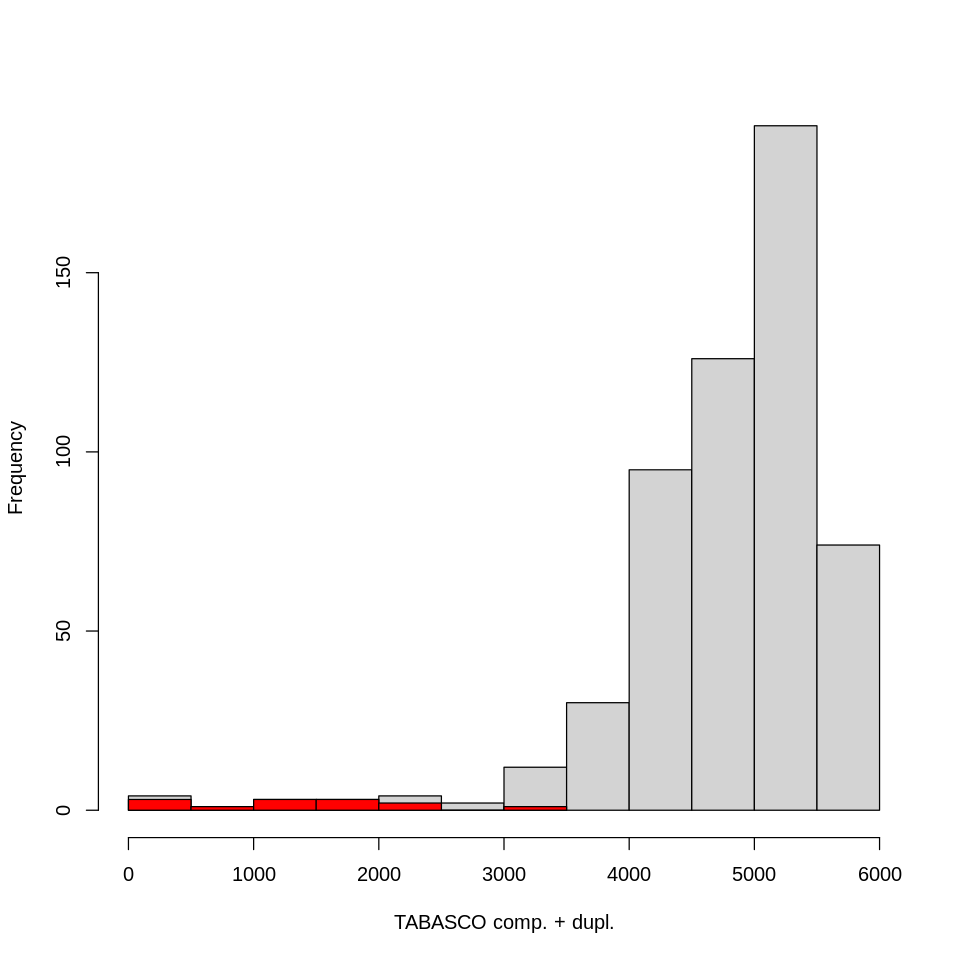

In [296]:
options(repr.plot.width=8, repr.plot.height=8)
hist((TABASCO[,2]+TABASCO[,3])[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1]],
     main = "",xlab = "TABASCO comp. + dupl.")
hist((TABASCO[,2]+TABASCO[,3])[rownames(TABASCO)%in%names(diff_SKtoM)[grepl('AN2|MCRTL',names(diff_SKtoM))]][-c(2:3)],
     add = T, col = "red")

In [301]:
head(TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],][order(TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],2]+TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],3]),],n = 16)
setdiff(rownames(head(TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],][order(TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],2]+TABASCO[rownames(TABASCO)%in%strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],3]),],n = 13)),names(diff_SKtoM)[grepl('AN2|MCRTL',names(diff_SKtoM))])

assemblyID   complete duplicated fraged missing technology      
MCRTL043     MCRTL043      123        2       4040   1427    Illumina        
AN21TSTL0285 AN21TSTL0285  128        1        744   4719    Illumina        
ASM3043976v1 ASM3043976v1   99      153        374   4966    PacBio Sequel II
AN20T027     AN20T027      303        7       4503    779    Illumina        
AN22TNTL157  AN22TNTL157   626       14       4780    172    Illumina        
AN21TSTL0263 AN21TSTL0263 1148       23       4310    111    Illumina        
AN21TSTL0264 AN21TSTL0264 1156       22       4248    166    Illumina        
AN21TSTL0243 AN21TSTL0243 1190        8       4141    253    Illumina        
AN22TNTL007  AN22TNTL007  1577       45       3927     43    Illumina        
AN21TSTL0244 AN21TSTL0244 1627       95       3836     34    Illumina        
AN22TNTL008  AN22TNTL008  1867       37       3641     47    Illumina        
AN21TSTL0254 AN21TSTL0254 1941      273       3350     28    Illumina        
AN22TSTL001  AN22TSTL001  2312       35       3228     17    Illumina        
AN21TS46     AN21TS46     1410     1009       3167      6    Illumina        
AN22TNTL166  AN22TNTL166  2412       77       3073     30    Illumina        
AN21TNTL0082 AN21TNTL0082 2320      262       3005      5    Illumina

[1] "ASM3043976v1"

In [304]:
2347/(123+2+4040+1427)

[1] 0.4197067

In [298]:
TABASCO["MCRTL021",]

assemblyID complete duplicated fraged missing technology
MCRTL021 MCRTL021   1785     2618       1188   1       Illumina

In [330]:
mTre.rooted.renamed = root(mTre.renamed,"P.vaginatum_v3.1:Paspalum vaginatum")
mTre.rooted.renamed


Phylogenetic tree with 482 tips and 481 internal nodes.

Tip labels:
  AN21TS53:Anatherum macrothrix, AN21TS57:Anatherum selloanum, AN22TNTL110:Andropogon carinatus, AN21TNTL0111:Andropogon ingratus, AN21TSTL0184:Anatherum glomeratum, AN21TS04:Anatherum brachystachyum, ...
Node labels:
  NA-NA-NA-NA, 1.00-0.98-0.01-0.01, 0.81-0.40-0.25-0.35, 0.54-0.36-0.32-0.32, 0.82-0.40-0.28-0.32, 0.47-0.35-0.34-0.31, ...

Rooted; includes branch length(s).

In [331]:
spTre.rooted.renamed.andro


Phylogenetic tree with 501 tips and 500 internal nodes.

Tip labels:
  P.vaginatum_v3.1:Paspalum vaginatum, AN21TSTL0188:Arthraxon hispidus, AN20T174:Arthraxon antsirabensis, AN22TNTL028:Arthraxon cuspidatus, AN21TS30:Arthraxon junnarensis, AN21TNTL0106:Arthraxon lancifolius, ...
Node labels:
  1.000000, 0.890232, 1.000000, 1.000000, 1.000000, 1.000000, ...

Rooted; includes branch length(s).

In [360]:
subtribe_col = rainbow(20)[factor(taxanomicGroup[strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],6],
                                  levels = sort(unique(taxanomicGroup[strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],6])))]

subtribe_col[is.na(subtribe_col)] = "grey"

In [361]:
subtribe_col2 = rainbow(20)[factor(taxanomicGroup[strsplit2(mTre.rooted.renamed$tip.label,":")[,1],6],
                                  levels = sort(unique(taxanomicGroup[strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],6])))]

subtribe_col2[is.na(subtribe_col2)] = "grey"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

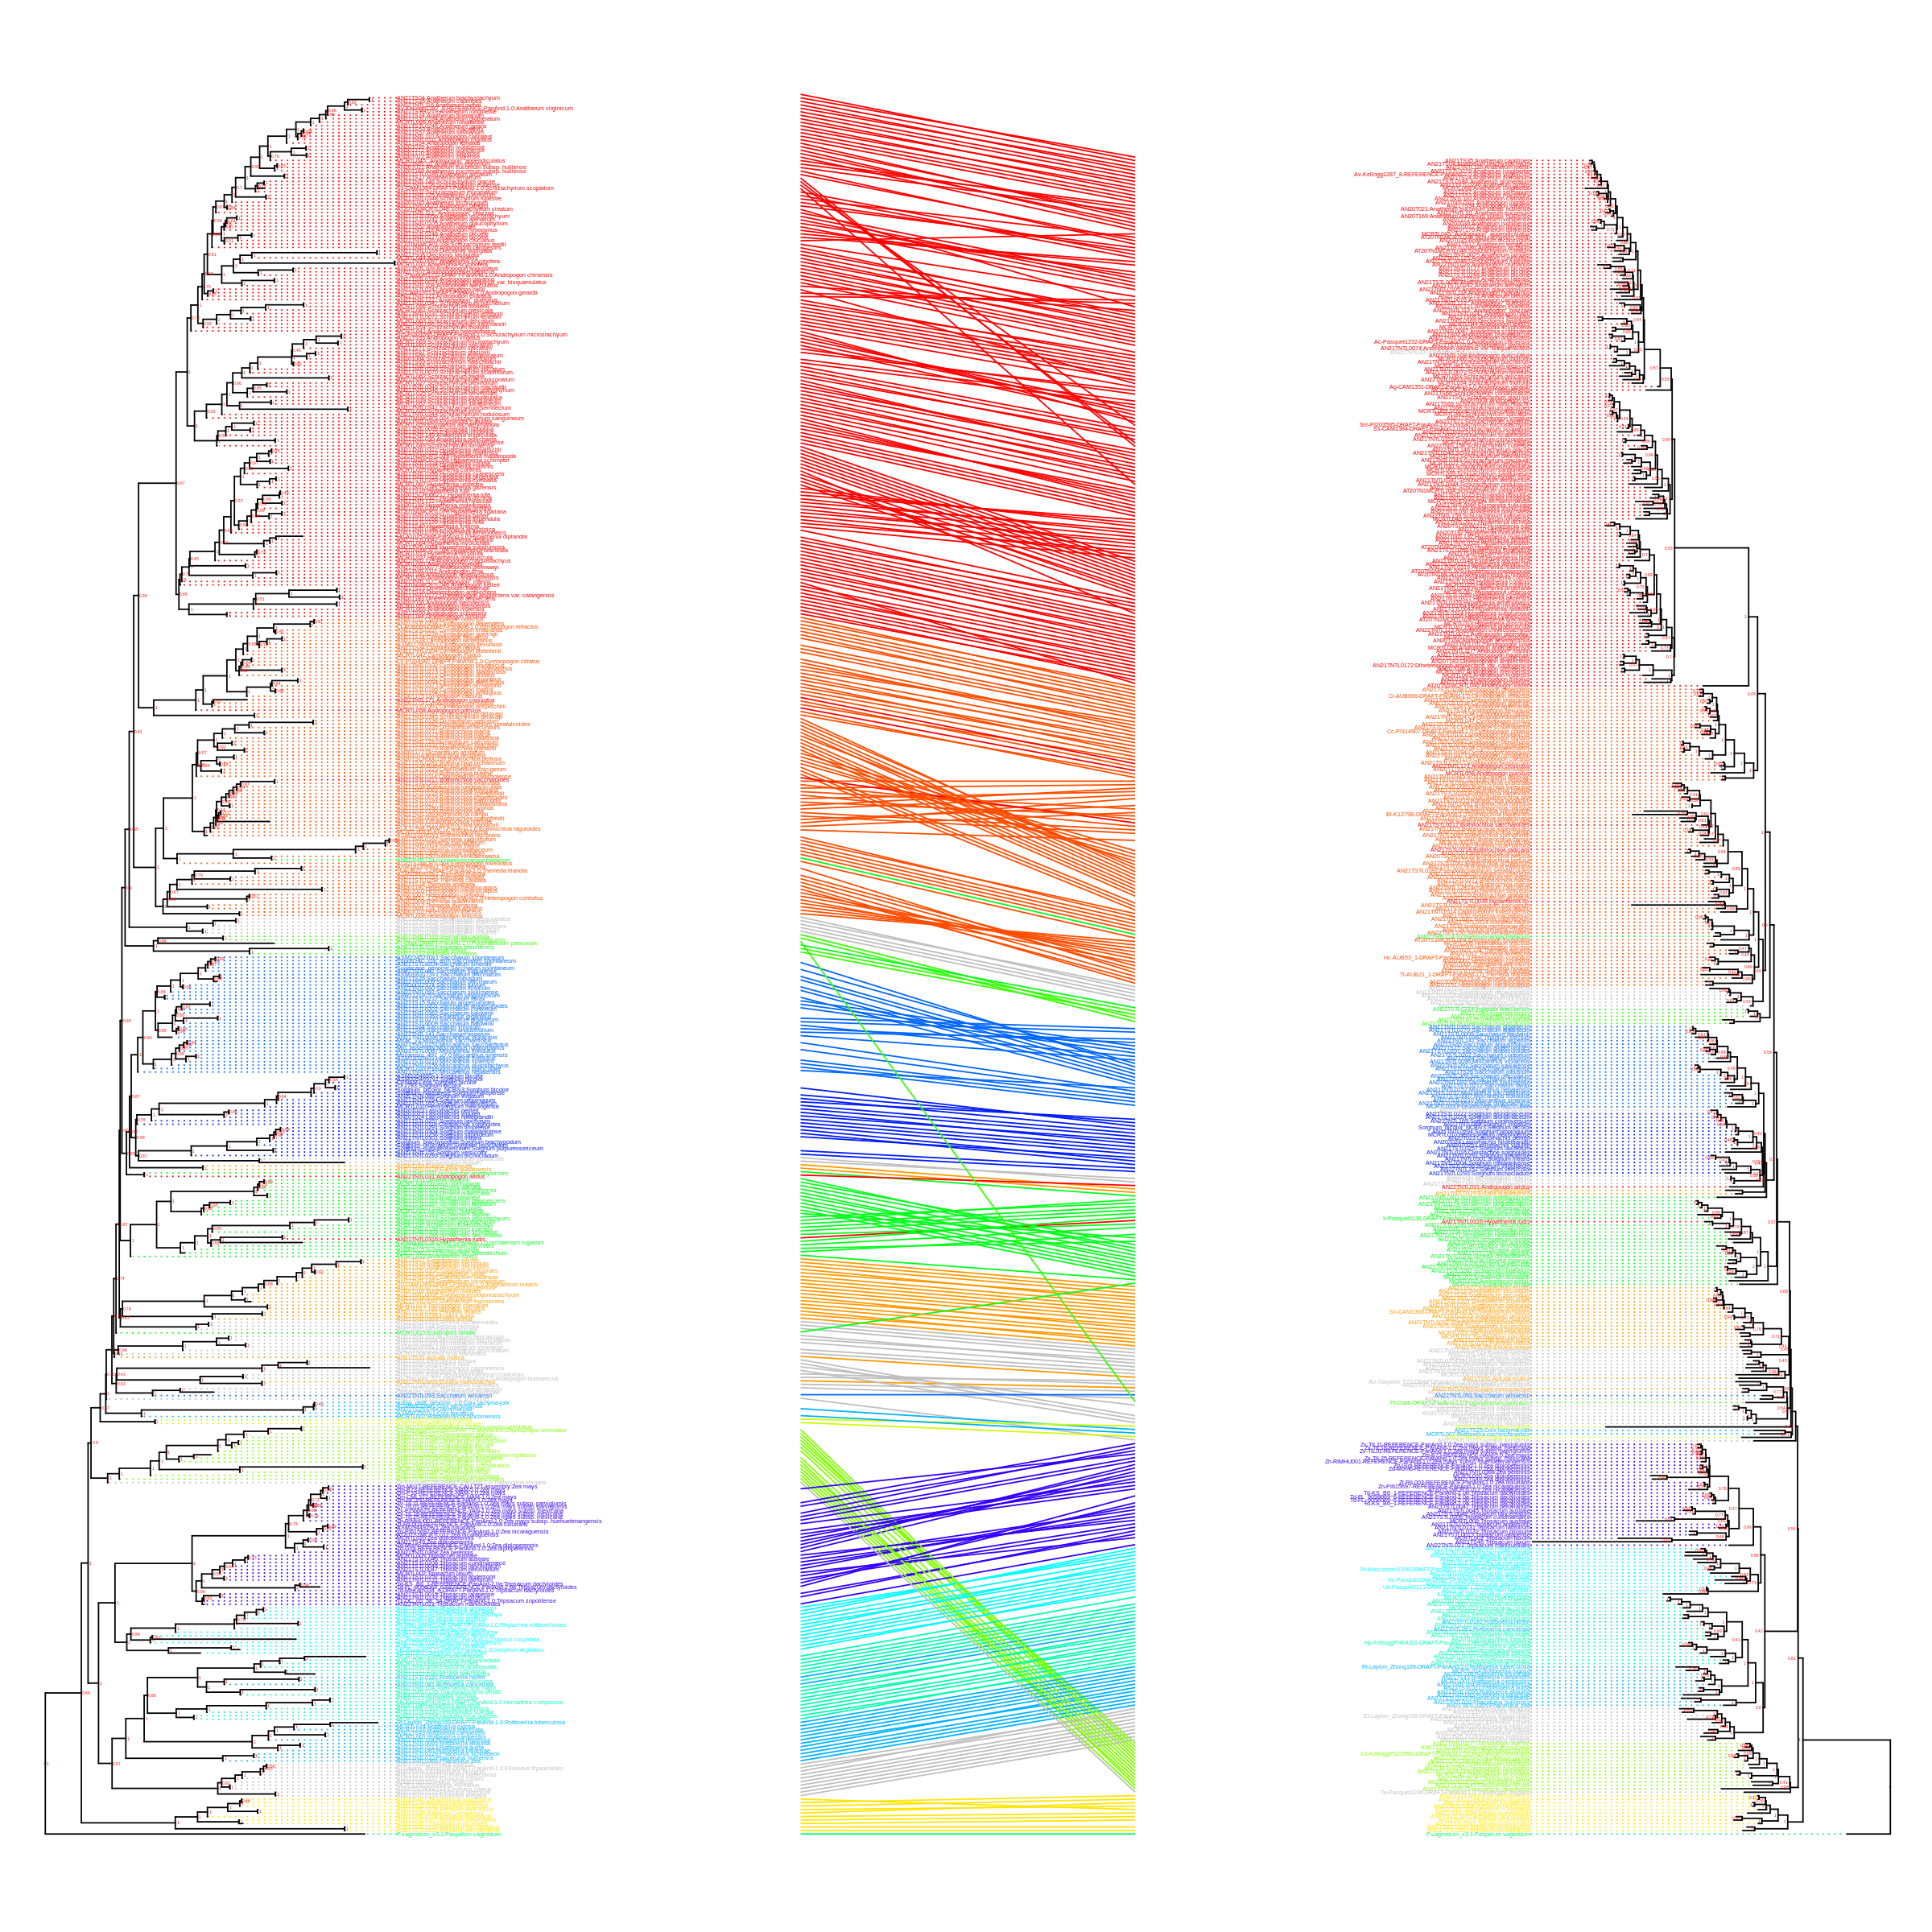

In [362]:
library(cowplot)

options(repr.plot.width=20, repr.plot.height=20)
T1=ggtree(spTre.rooted.renamed.andro)+
    theme_tree2(legend.position='none',plot.margin = unit(c(0,0,0,0),"cm"))+
    geom_tiplab()
T2=ggtree(mTre.rooted.renamed)+
    theme_tree2(legend.position='none',plot.margin = unit(c(0,0,0,0),"cm"))+
    geom_tiplab(hjust=1)+ scale_x_reverse()

d1 = T1$data[T1$data$isTip,]  
d1$x[] = 1  
d2 = T2$data[T2$data$isTip,]  
d2$x[] = 2  

TTcon = rbind(d1, d2) 
TTcon$subtribe = taxanomicGroup[strsplit2(TTcon$label,":")[,1],6]
TTcon$subtribe[is.na(TTcon$subtribe)] = "unknown"
TTcon$subtribe = factor(TTcon$subtribe,
                        levels = c(sort(unique(taxanomicGroup[strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],6])),"unknown"))

spTre.rooted.renamed.andro$node.label = round(as.numeric(strsplit2(spTre.rooted.renamed.andro$node.label,"-")[,1]),2)
T1 = ggtree(spTre.rooted.renamed.andro) + 
    ylim(1,501)+
    xlim(0,15)+
    geom_nodelab(vjust=.5,hjust = 0.1, size=1,color = "red") +
  geom_tiplab(align = T,size=1.5,color=subtribe_col)  

mTre.rooted.renamed$node.label = round(as.numeric(strsplit2(mTre.rooted.renamed$node.label,"-")[,1]),2)
T2 = ggtree(mTre.rooted.renamed) +   
    geom_tiplab(hjust =1, align = T,size=1.5,color=subtribe_col2)  +
    ylim(1,501)+
    geom_nodelab(vjust=.5,hjust = 1, size=1,color = "red") +
    scale_x_reverse(lim = c(.6,0)) 

L1 = ggplot(TTcon, aes(x = x, y = y, col = subtribe, group = label)) + geom_line() +   
    scale_color_manual(values = c(rainbow(20)[1:15],"grey"))+
    theme_void() + 
    theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm"))

cowplot::plot_grid(T1, L1 ,T2, nrow = 1, align = "hv",rel_widths = c(2,1,2))
png("/workdir/sh2246/p_phyloGWAS/output/andropogoneaeASTRALTreesComparison_20250407.png",
    height=80,width=30,units="cm",pointsize = 4,res=600)
cowplot::plot_grid(T1, L1 ,T2, nrow = 1, align = "hv",rel_widths = c(2,1,2))
dev.off()

In [254]:
TABASCO[c("AN22TNTL081","AN21TSTL0182","AN21TS31","MCRTL015","AN21TNTL0316","AN22TNTL031","AN22TNTL124"),]

assemblyID   complete duplicated fraged missing technology
AN22TNTL081  AN22TNTL081  5293      100       196    3       Illumina  
AN21TSTL0182 AN21TSTL0182 4708       98       781    5       Illumina  
AN21TS31     AN21TS31     3873      800       916    3       Illumina  
MCRTL015     MCRTL015     4722      409       460    1       Illumina  
AN21TNTL0316 AN21TNTL0316 5007      115       469    1       Illumina  
AN22TNTL031  AN22TNTL031  4351      416       821    4       Illumina  
AN22TNTL124  AN22TNTL124  3679     1000       907    6       Illumina

In [111]:
taxanomicGroup[strsplit2(spTre.rooted.renamed.andro$tip.label,":")[,1],7]

[1] "Paspalinae"      "Andropogoninae"  "Arthraxoninae"   "Arthraxoninae"  
  [5] "Arthraxoninae"   "Arthraxoninae"   "Arthraxoninae"   "Arthraxoninae"  
  [9] "Arthraxoninae"   "Arthraxoninae"   "Arthraxoninae"   "Arthraxoninae"  
 [13] "Arthraxoninae"   "Rottboelliinae"  "Rottboelliinae"  "Rottboelliinae" 
 [17] "Rottboelliinae"  "Ratzeburgiinae"  "Rottboelliinae"  "Rottboelliinae" 
 [21] "Rottboelliinae"  "Germainiinae"    "Rottboelliinae"  "Ratzeburgiinae" 
 [25] "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae" 
 [29] "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae" 
 [33] "Ratzeburgiinae"  "Rottboelliinae"  "Ratzeburgiinae"  "Rottboelliinae" 
 [37] "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae"  "Ratzeburgiinae" 
 [41] "Ratzeburgiinae"  NA                "Apludinae"       NA               
 [45] NA                NA                NA                NA               
 [49] NA                "Ratzeburgiinae"  NA                NA               
 [53] NA                NA                NA                NA               
 [57] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [61] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [65] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [69] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [73] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [77] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [81] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [85] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [89] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Tripsacinae"    
 [93] "Tripsacinae"     "Tripsacinae"     "Tripsacinae"     "Rhytachninae"   
 [97] "Rhytachninae"    "Rhytachninae"    "Rhytachninae"    "Rhytachninae"   
[101] "Rhytachninae"    "Rhytachninae"    "Rhytachninae"    "Rhytachninae"   
[105] "Rhytachninae"    NA                NA                "Rhytachninae"   
[109] "Rhytachninae"    "Rhytachninae"    "Rhytachninae"    "Rhytachninae"   
[113] "Rhytachninae"    "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae"
[117] "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae" "Anthistiriinae" 
[121] "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae"
[125] "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae" "Chrysopogoninae"
[129] NA                "Chrysopogoninae" NA                NA               
[133] "Chionachninae"   "Chionachninae"   "Rottboelliinae"  "Rottboelliinae" 
[137] "Rottboelliinae"  "Rottboelliinae"  "Rottboelliinae"  NA               
[141] NA                "Saccharinae"     NA                "Saccharinae"    
[145] NA                "Apludinae"       "Andropogoninae"  NA               
[149] "Anthistiriinae"  NA                NA                NA               
[153] NA                NA                NA                NA               
[157] NA                NA                NA                NA               
[161] "Apludinae"       "Ischaeminae"     NA                NA               
[165] NA                "Apludinae"       "Apludinae"       "Apludinae"      
[169] "Apludinae"       "Apludinae"       "Ratzeburgiinae"  "Apludinae"      
[173] "Apludinae"       "Apludinae"       "Apludinae"       "Apludinae"      
[177] "Apludinae"       "Apludinae"       "Apludinae"       "Apludinae"      
[181] "Apludinae"       "Apludinae"       "Apludinae"       "Ischaeminae"    
[185] "Ischaeminae"     "Andropogoninae"  "Ischaeminae"     "Ischaeminae"    
[189] "Ischaeminae"     "Ischaeminae"     "Ischaeminae"     "Ischaeminae"    
[193] "Ischaeminae"     "Ischaeminae"     "Ischaeminae"     "Ischaeminae"    
[197] "Ischaeminae"     "Ischaeminae"     "Ischaeminae"     "Ischaeminae"    
[201] "Ischaeminae"     "Ischaeminae"     "Ischaeminae"     "Ischaeminae"    
[205] "Ischaeminae"     

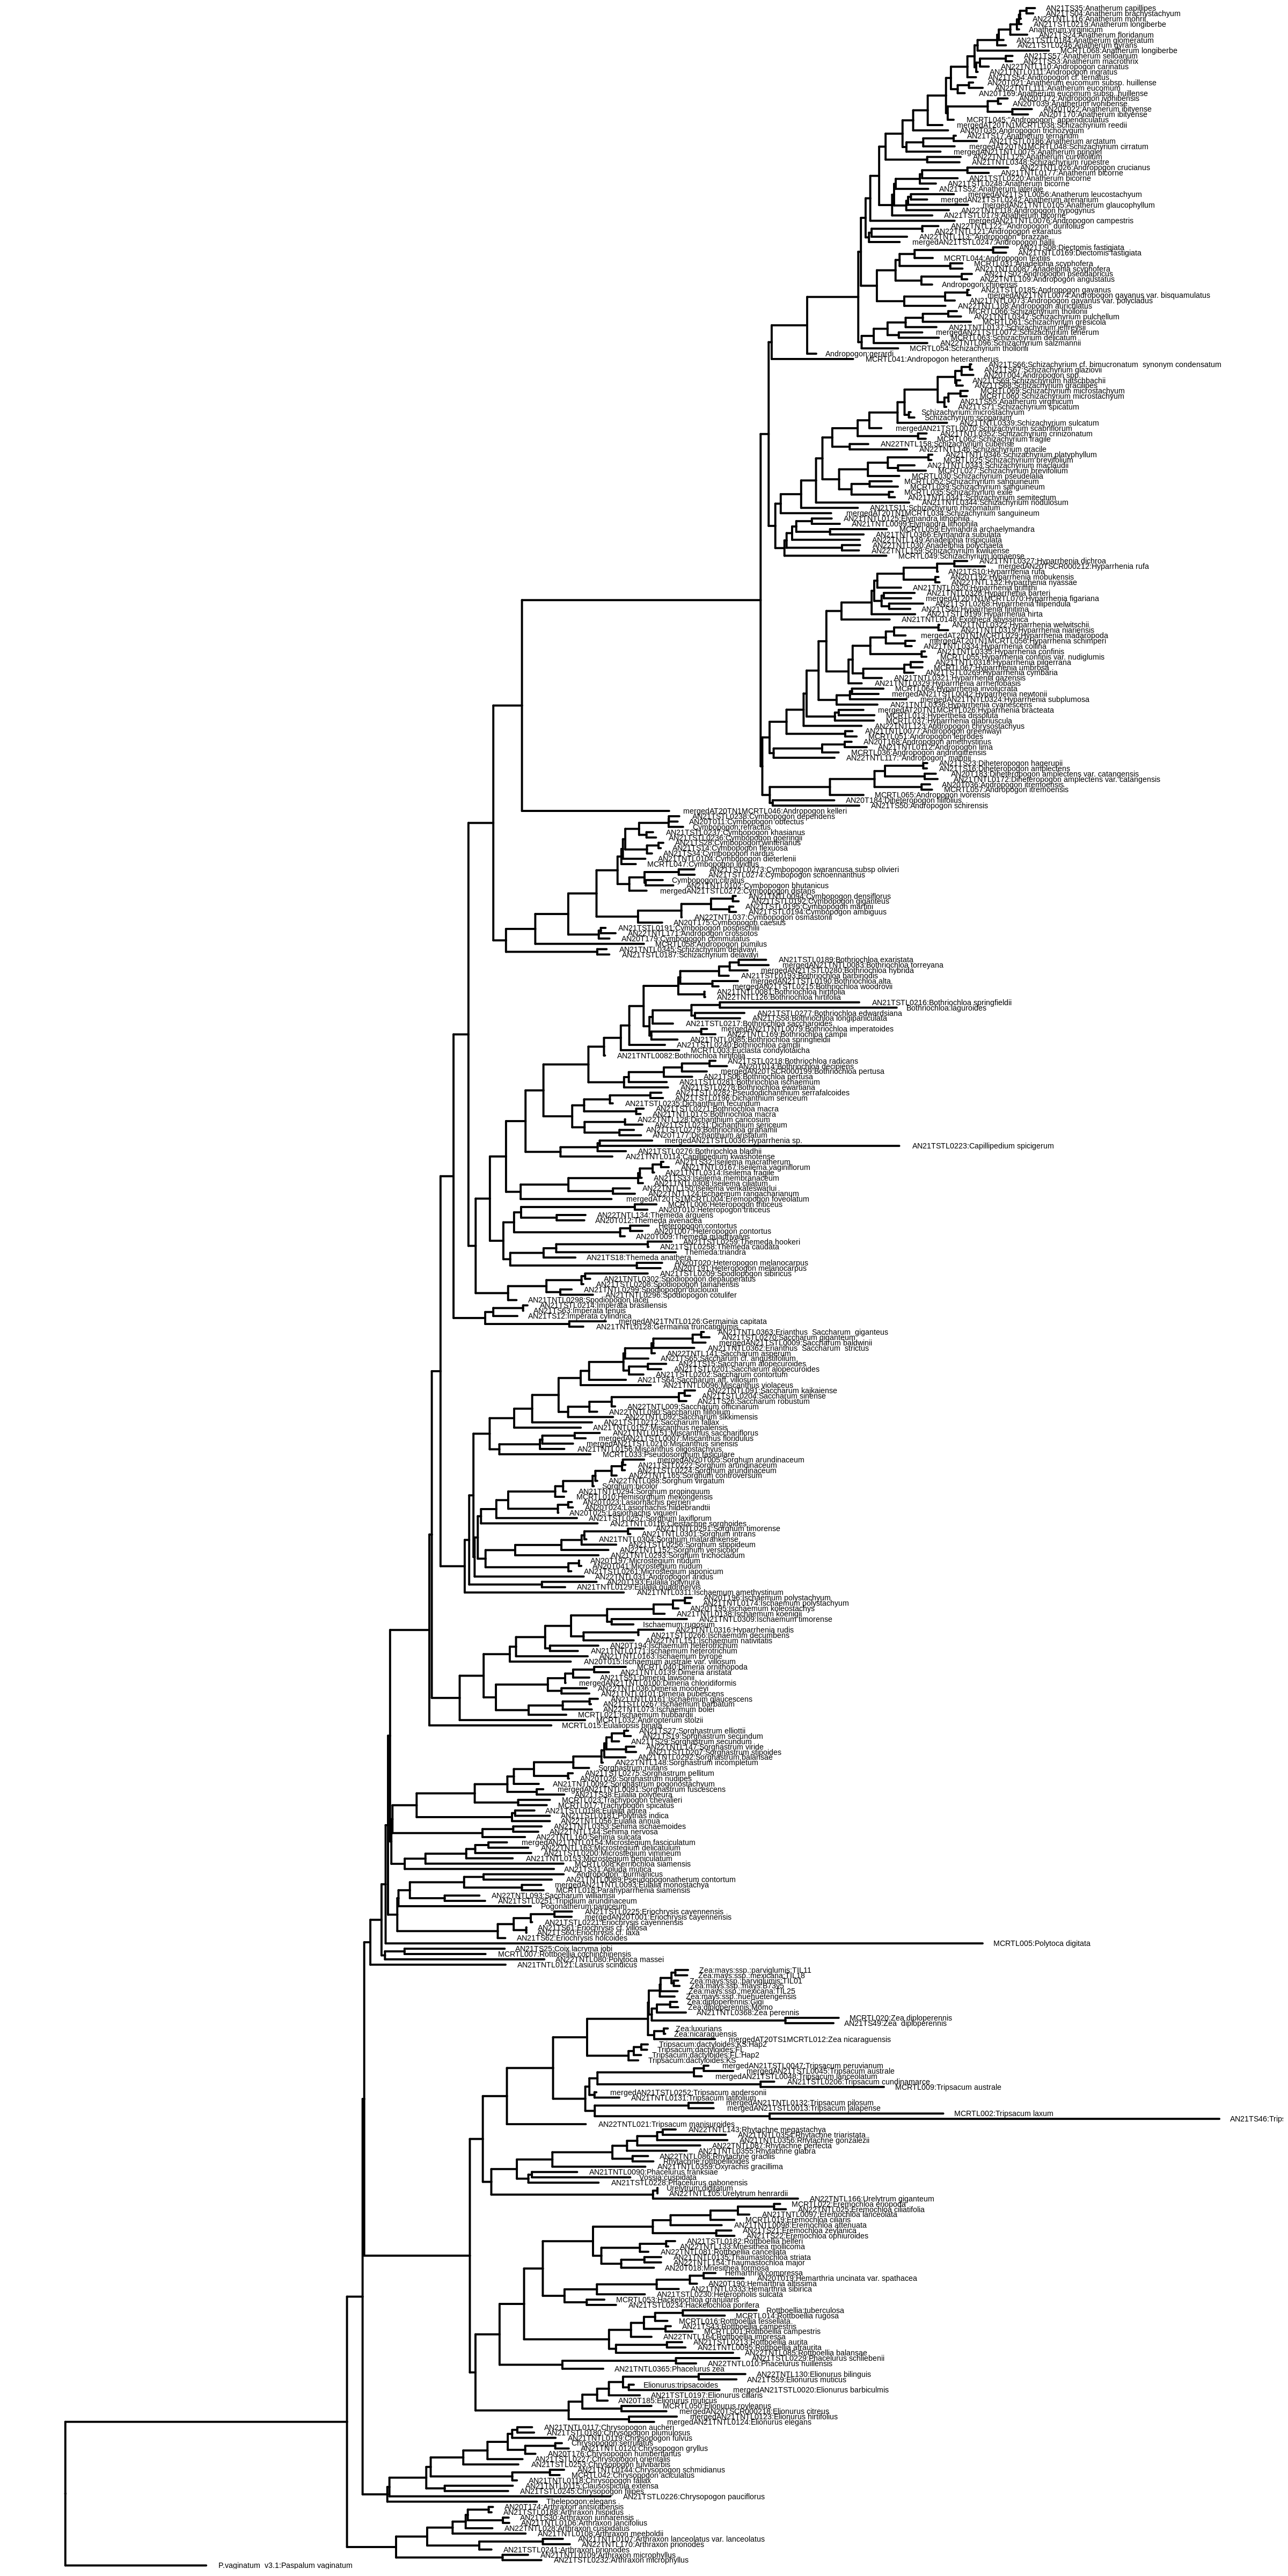

In [38]:
options(repr.plot.width=20, repr.plot.height=40)

ggtree(mTre.rooted.renamed,size =1.1,ladderize = T ) + 
geom_tiplab(hjust = -.05,size=3) +
theme(legend.position = c(.1,.95),
      legend.text = element_text(size = 10),
      legend.title = element_text(size = 12)) 